# Lyric Mood Classification - Mood Classification

In the [word_embeddings](word_embeddings.ipynb) notebook, we demonstrated our embeddings model based on word2vec. In this notebook, we use those embeddings to produce real classification results with a neural network.

First, we split our labeled data into the classic train-dev-test split.

Second, we establish a baseline classification with simple classifiers.

Third, we demonstrate our neural network architecture and model for mood classification.

In [34]:
from index_lyrics import read_file_contents
from label_lyrics import CSV_LABELED_LYRICS
from scrape_lyrics import LYRICS_TXT_DIR
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import lyrics2vec
import datetime
import time
import os

%matplotlib inline

## Dataset

The dataset consists of a large number of text files where each file represents a different song. The songs are indexed by a csv file produced by `label_lyrics.py`. We can use the index to retrieve a song's lyrics and observe its matched mood.

We drop all songs that are not english, do not have lyrics available, and do not have a matched mood as classifying across languages is out of scope of this project and no classification can be done on a song without lyrics or without a matched mood.

In [2]:
# we leave out the musixmatch id, artist, and title cols
df = pd.read_csv(CSV_LABELED_LYRICS, usecols=['msd_id', 'msd_artist', 'msd_title', 'is_english', 'lyrics_available', 'wordcount', 'lyrics_filename', 'mood', 'found_tags', 'matched_mood'])
df.columns

/home/jcworkma/jack/w266-group-project_lyric-mood-classification/.venv_w266_project/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['msd_id', 'msd_artist', 'msd_title', 'is_english', 'lyrics_available',
       'wordcount', 'lyrics_filename', 'mood', 'found_tags', 'matched_mood'],
      dtype='object')

In [3]:
print('Df shape:', df.shape)
df.describe()

Df shape: (779056, 10)


,is_english,lyrics_available,wordcount,found_tags,matched_mood
count,779056.000000,779056.000000,779056.000000,779056.000000,779056.000000
mean,0.342566,0.420039,87.716389,5.870052,-0.611558
std,0.474571,0.493565,141.151970,19.502538,0.574065
min,-1.000000,0.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,0.000000,0.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,-1.000000,-1.000000
75%,1.000000,1.000000,161.000000,1.000000,0.000000
max,1.000000,1.000000,8623.000000,100.000000,1.000000


In [4]:
df = df[df.is_english == 1]
print('After is_english filter:', df.shape)
df = df[df.lyrics_available == 1]
print('After lyrics_available filter:', df.shape)
df = df[df.matched_mood == 1]
print('After matched_mood filter:', df.shape)

After is_english filter: (266879, 10)
After lyrics_available filter: (266783, 10)
After matched_mood filter: (35835, 10)


In [5]:
# remove no longer needed columns to conserve memory
df = df.drop(['is_english', 'lyrics_available', 'matched_mood'], axis=1)

In [6]:
# create a categorical data column for moods
# thank you: https://stackoverflow.com/questions/38088652/pandas-convert-categories-to-numbers
df.mood = pd.Categorical(df.mood)
df['mood_cats'] = df.mood.cat.codes
print(df['mood_cats'].unique())
print(df.shape)

[ 7  2 14 16  3 15 10  0  4 12  1 11  5  8  9 13  6]
(35835, 8)


In [7]:
# read in the lyrics of each song
def extract_lyrics(lyrics_filepath):
    lyrics = ''
    if os.path.exists(lyrics_filepath):
        lyrics = read_file_contents(lyrics_filepath)[0]
    return lyrics

def make_lyrics_txt_path(lyrics_filename):
    return os.path.join(LYRICS_TXT_DIR, lyrics_filename) + '.txt'

# here we make use of panda's apply function to parallelize the IO operation
df['lyrics'] = df.lyrics_filename.apply(lambda x: extract_lyrics(make_lyrics_txt_path(x)))
df.lyrics.head()

7     Electro eroticism\nIntelligence is sexy\nElect...
19    I'm in the dark, I'd like to read his mind\nBu...
27    I'm in the dark, I'd like to read his mind\nBu...
28    One night in Iowa, he and I in a borrowed car\...
32    Shall we agree that just this once\nI'm gonna ...
Name: lyrics, dtype: object

The final number of songs with a matched mood: 35835


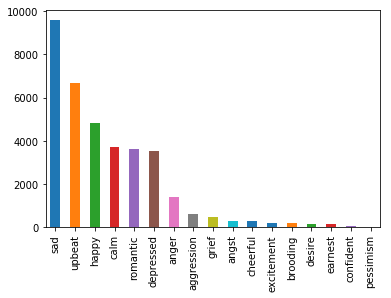

In [8]:
print('The final number of songs with a matched mood:', df.shape[0])
_ = df.mood.value_counts().plot(kind='bar')

## Train, Dev, & Test

With our dataset index in hand, we are prepared to split the data.

In [9]:
# thank you: https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test/38251213#38251213
# optional random dataframe shuffle
#df = df.reindex(np.random.permutation(df.index))
np.random.seed(12)
def split_data(data):
    return np.split(data.sample(frac=1), [int(.6*len(data)), int(.8*len(data))])

df_train, df_dev, df_test = split_data(df)

In [10]:
print('Train:', df_train.shape)
print('Dev:', df_dev.shape)
print('Test:', df_test.shape)

Train: (21501, 9)
Dev: (7167, 9)
Test: (7167, 9)


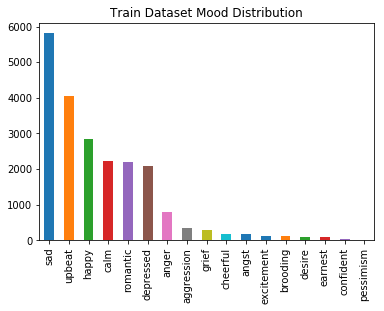

In [11]:
# thank you: https://stackoverflow.com/questions/14992644/turn-pandas-dataframe-of-strings-into-histogram
_ = df_train.mood.value_counts().plot(kind='bar', title='Train Dataset Mood Distribution')

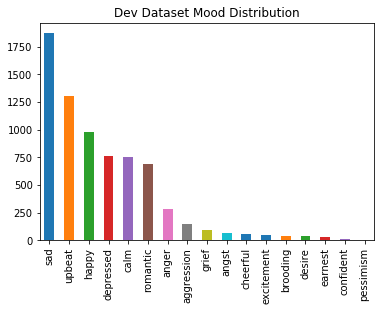

In [12]:
_ = df_dev.mood.value_counts().plot(kind='bar', title='Dev Dataset Mood Distribution')

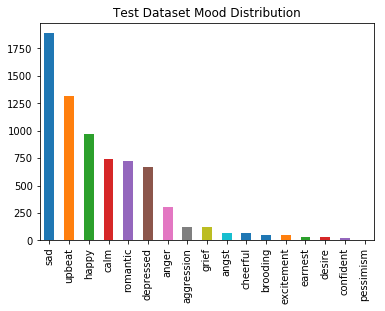

In [13]:
_ = df_test.mood.value_counts().plot(kind='bar', title='Test Dataset Mood Distribution')

## Baselines

### Most-Common-Case Classification

In [14]:
def pprint_accuracy(acc):
    return '{0:.02f}%'.format(acc * 100)

def most_common_case_classification(x, y):
    assert len(x) == len(y)
    total_count = len(x)
    common_count = y.value_counts().max()
    accuracy = common_count / total_count
    return accuracy

In [15]:
print('The most common case for each dataset split is')
print('\tTrain:', df_train.mood.value_counts().idxmax())
print('\tDev:', df_dev.mood.value_counts().idxmax())
print('\tTest:', df_test.mood.value_counts().idxmax())
#df_test.loc[df_test.mood_classes.idxmax()].mood
print('The accuracy of the most-common-case classifier for each dataset split is')
print('\tTrain:', pprint_accuracy(most_common_case_classification(df_train.lyrics_filename, df_train.mood)))
print('\tDev:', pprint_accuracy(most_common_case_classification(df_dev.lyrics_filename, df_dev.mood)))
print('\tTest:', pprint_accuracy(most_common_case_classification(df_test.lyrics_filename, df_test.mood)))


The most common case for each dataset split is
	Train: sad
	Dev: sad
	Test: sad
The accuracy of the most-common-case classifier for each dataset split is
	Train: 27.02%
	Dev: 26.11%
	Test: 26.34%


### Naive-Bayes Classification

The Naive-Bayes Classifier will require the actual lyrical text for classification, so we begin by reading into memory the text for each song in our dataset.

Once we have the lyrics, we use the python sklearn package to vectorize and process the lyrical text, fit the Naive Bayes Classifier, and compute the accuracy.

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

def prep_lyrics_for_nb(lyrics_series, count_vect=None, tfidf_transformer=None):
   # thank you: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
    if not count_vect:
        count_vect = CountVectorizer()
        count_vect = count_vect.fit(lyrics_series)
    x_train_counts = count_vect.transform(lyrics_series)
    if not tfidf_transformer:
        tfidf_transformer = TfidfTransformer()
        tfidf_transformer = tfidf_transformer.fit(x_train_counts)
    x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)
    return count_vect, x_train_counts, tfidf_transformer, x_train_tfidf

# convert lyrics to counts and term-frequencies
count_vect, x_train_counts, tfidf_transformer, x_train_tfidf = prep_lyrics_for_nb(df_train.lyrics)
print(x_train_tfidf.shape)
_, x_dev_counts, _, x_dev_tfidf = prep_lyrics_for_nb(df_dev.lyrics, count_vect, tfidf_transformer)
print(x_dev_tfidf.shape)
_, x_test_counts, _, x_test_tfidf = prep_lyrics_for_nb(df_test.lyrics, count_vect, tfidf_transformer)
print(x_test_tfidf.shape)

(21501, 42154)
(7167, 42154)
(7167, 42154)


In [17]:
clf = MultinomialNB().fit(x_train_tfidf, df_train.mood_cats) 
dev_acc = clf.score(x_dev_tfidf, df_dev.mood_cats)
print('Naive Bayes Classifier Dev Accuracy:', pprint_accuracy(dev_acc))
test_acc = clf.score(x_test_tfidf, df_test.mood_cats)
print('Naive Bayes Classifier Test Accuracy:', pprint_accuracy(test_acc))

Naive Bayes Classifier Dev Accuracy: 29.64%
Naive Bayes Classifier Test Accuracy: 30.25%


### SVM Classification

From [Corona & O'Mahony](https://www.researchgate.net/publication/280733696_An_Exploration_of_Mood_Classification_in_the_Million_Songs_Dataset), SVMs have been used with success in this area. Here we see that they do provide a sizeable increase in accuracy over NB.

In [18]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42,
            max_iter=5, tol=None).fit(x_train_tfidf, df_train.mood_cats)
dev_acc = clf.score(x_dev_tfidf, df_dev.mood_cats)
print('SVM Classifier Dev Accuracy:', pprint_accuracy(dev_acc))
test_acc = clf.score(x_test_tfidf, df_test.mood_cats)
print('SVM Classifier Test Accuracy:', pprint_accuracy(test_acc))

SVM Classifier Dev Accuracy: 41.61%
SVM Classifier Test Accuracy: 42.47%


## Neural Networks

### CNN

http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/

CNNs process textual input different than a Naive Bayes or SVM classifier. We perform the following data processing steps on all lyrics:
* Truncate/extend all songs to the 75% wordcount percentile
* Tokenize lyrics with nltk's word_tokenize function
* Remove all stopwords that match from within nltk's stopwords corpus
* Remove punctuation

In [20]:
pctiles = df.wordcount.describe()
print(pctiles)
cutoff = int(pctiles[pctiles.index.str.startswith('75%')][0])
print('\nAll songs will be limited to {0} words'.format(cutoff))

count    35835.000000
mean       228.451430
std        125.205067
min          1.000000
25%        147.000000
50%        207.000000
75%        282.000000
max       2913.000000
Name: wordcount, dtype: float64

All songs will be limited to 282 words


In [29]:
from importlib import reload
reload(lyrics2vec)
lyrics_vectorizer = lyrics2vec.lyrics2vec.InitFromLyrics()

In [30]:
def normalize_lyrics(lyrics, max_length, lyrics_vectorizer):
    """
    Tokenize, process, shorten/lengthen, and vectorize lyrics
    """
    lyrics = lyrics2vec.lyrics_preprocessing(lyrics)
    if len(lyrics) > max_length:
        lyrics = lyrics[:max_length]
    else:
        lyrics += ['<PAD>'] * (int(max_length) - int(len(lyrics)))

    lyric_vector = lyrics_vectorizer.transform(lyrics)
    return lyric_vector

start = time.time()

# here we make use of panda's apply function to parallelize the IO operation (again)
df_train['normalized_lyrics'] = df_train.lyrics.apply(lambda x: normalize_lyrics(x, cutoff, lyrics_vectorizer))
print('train data normalized ({0} minutes)'.format((time.time() - start) / 60))
print(df_train.normalized_lyrics.head())

df_dev['normalized_lyrics'] = df_dev.lyrics.apply(lambda x: normalize_lyrics(x, cutoff, lyrics_vectorizer))
print('dev data normalized ({0} minutes)'.format((time.time() - start) / 60))
print(df_dev.normalized_lyrics.head())

df_test['normalized_lyrics'] = df_test.lyrics.apply(lambda x: normalize_lyrics(x, cutoff, lyrics_vectorizer))
print('test data normalized ({0} minutes)'.format((time.time() - start) / 60))
print(df_test.normalized_lyrics.head())

print('\nExample of padding:')
example = df_train.normalized_lyrics[df_train.normalized_lyrics.str.len() == cutoff].iloc[0]
print('\tFirst 5 tokens: {0}'.format(example[:5]))
print('\tLast 5 tokens: {0}.'.format(example[-5:]))

print('\nElapsed Time: {0} minutes'.format((time.time() - start) / 60))

train data normalized (0.45991339683532717 minutes)
167425    [22, 1, 16, 6943, 5313, 6, 7, 13141, 2256, 89,...
30039     [296, 287, 215, 305, 1, 12153, 8, 297, 127, 6,...
13452     [112, 2902, 249, 763, 11223, 820, 601, 271, 18...
147252    [2, 210, 210, 13586, 70, 850, 704, 46, 159, 30...
141502    [63, 9, 101, 98, 505, 68, 172, 218, 27, 906, 6...
Name: normalized_lyrics, dtype: object
dev data normalized (0.6108621239662171 minutes)
108764    [65, 64, 1042, 449, 392, 1070, 1, 63, 23, 20, ...
200237    [417, 699, 366, 1353, 11396, 1325, 96, 812, 18...
69545     [37, 93, 15, 3458, 370, 2152, 450, 956, 970, 8...
26241     [238, 41, 86, 487, 29, 48, 312, 3, 492, 68, 30...
99874     [22, 1, 955, 9166, 399, 1273, 9166, 399, 4, 10...
Name: normalized_lyrics, dtype: object
test data normalized (0.7631547927856446 minutes)
113310    [59, 5580, 706, 59, 5580, 59, 5580, 174, 3129,...
160576    [37, 93, 1459, 544, 3950, 670, 3, 499, 2132, 3...
162776    [10909, 446, 132, 549, 96, 5859, 16, 719,

# **Following code is borrowed from [this excellent and very helpful blog post](http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/) to PoC the validity of the preprocessed tokens and word embeddings**

And here's a walkthrough of that blog post's code: https://agarnitin86.github.io/blog/2016/12/23/text-classification-cnn

In [35]:
class TextCNN(object):
    """
    A CNN for text classification.
    Uses an embedding layer, followed by a convolutional, max-pooling and softmax layer.
    """
    def __init__(
      self, sequence_length, num_classes, vocab_size,
      embedding_size, filter_sizes, num_filters, l2_reg_lambda=0.0):

        # Placeholders for input, output and dropout
        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

        # Keeping track of l2 regularization loss (optional)
        l2_loss = tf.constant(0.0)

        # Embedding layer
        with tf.device('/cpu:0'), tf.name_scope("embedding"):
            self.W = tf.Variable(
                tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0),
                name="W")
            self.embedded_chars = tf.nn.embedding_lookup(self.W, self.input_x)
            self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)

        # Create a convolution + maxpool layer for each filter size
        pooled_outputs = []
        for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                # Convolution Layer
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d(
                    self.embedded_chars_expanded,
                    W,
                    strides=[1, 1, 1, 1],
                    padding="VALID",
                    name="conv")
                # Apply nonlinearity
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                # Maxpooling over the outputs
                pooled = tf.nn.max_pool(
                    h,
                    ksize=[1, sequence_length - filter_size + 1, 1, 1],
                    strides=[1, 1, 1, 1],
                    padding='VALID',
                    name="pool")
                pooled_outputs.append(pooled)

        # Combine all the pooled features
        num_filters_total = num_filters * len(filter_sizes)
        self.h_pool = tf.concat(pooled_outputs, 3)
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])

        # Add dropout
        with tf.name_scope("dropout"):
            self.h_drop = tf.nn.dropout(self.h_pool_flat, self.dropout_keep_prob)

        # Final (unnormalized) scores and predictions
        with tf.name_scope("output"):
            W = tf.get_variable(
                "W",
                shape=[num_filters_total, num_classes],
                initializer=tf.contrib.layers.xavier_initializer())
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            self.scores = tf.nn.xw_plus_b(self.h_drop, W, b, name="scores")
            self.predictions = tf.argmax(self.scores, 1, name="predictions")

        # Calculate mean cross-entropy loss
        with tf.name_scope("loss"):
            losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.scores, labels=self.input_y)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss

        # Accuracy
        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")

In [36]:
# Parameters
# ==================================================

# Model Hyperparameters
embedding_dim = 128
filter_sizes = [3,4,5]
num_filters = 128
dropout_keep_prob = 0.5
l2_reg_lambda = 0.0

# Training parameters
batch_size = 64
num_epochs = 200
evaluate_every = 100
checkpoint_every = 100
num_checkpoints = 5

def batch_iter(data, batch_size, num_epochs, shuffle=True):
    """
    Generates a batch iterator for a dataset.
    """
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    for epoch in range(num_epochs):
        # Shuffle the data at each epoch
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]
            
def train(x_train, y_train, vocab_size, x_dev, y_dev):
    # Training
    # ==================================================

    with tf.Graph().as_default():
        session_conf = tf.ConfigProto()
        sess = tf.Session(config=session_conf)
        with sess.as_default():
            cnn = TextCNN(
                sequence_length=x_train.shape[1],
                num_classes=y_train.shape[1],
                #vocab_size=len(vocab_processor.vocabulary_),
                vocab_size=vocab_size,
                embedding_size=embedding_dim,
                filter_sizes=filter_sizes,
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda)

            # Define Training procedure
            global_step = tf.Variable(0, name="global_step", trainable=False)
            optimizer = tf.train.AdamOptimizer(1e-3)
            grads_and_vars = optimizer.compute_gradients(cnn.loss)
            train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

            # Keep track of gradient values and sparsity (optional)
            grad_summaries = []
            for g, v in grads_and_vars:
                if g is not None:
                    grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
                    sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                    grad_summaries.append(grad_hist_summary)
                    grad_summaries.append(sparsity_summary)
            grad_summaries_merged = tf.summary.merge(grad_summaries)

            # Output directory for models and summaries
            timestamp = str(int(time.time()))
            out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
            print("Writing to {}\n".format(out_dir))
            
            # Summaries for loss and accuracy
            loss_summary = tf.summary.scalar("loss", cnn.loss)
            acc_summary = tf.summary.scalar("accuracy", cnn.accuracy)

            # Train Summaries
            train_summary_op = tf.summary.merge([loss_summary, acc_summary, grad_summaries_merged])
            train_summary_dir = os.path.join(out_dir, "summaries", "train")
            train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

            # Dev summaries
            dev_summary_op = tf.summary.merge([loss_summary, acc_summary])
            dev_summary_dir = os.path.join(out_dir, "summaries", "dev")
            dev_summary_writer = tf.summary.FileWriter(dev_summary_dir, sess.graph)

            # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
            checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
            checkpoint_prefix = os.path.join(checkpoint_dir, "model")
            if not os.path.exists(checkpoint_dir):
                os.makedirs(checkpoint_dir)
            saver = tf.train.Saver(tf.global_variables(), max_to_keep=num_checkpoints)

            # Write vocabulary
            #vocab_processor.save(os.path.join(out_dir, "vocab"))

            # Initialize all variables
            sess.run(tf.global_variables_initializer())

            def train_step(x_batch, y_batch):
                """
                A single training step
                """
                feed_dict = {
                  cnn.input_x: x_batch,
                  cnn.input_y: y_batch,
                  cnn.dropout_keep_prob: dropout_keep_prob
                }
                _, step, summaries, loss, accuracy = sess.run(
                    [train_op, global_step, train_summary_op, cnn.loss, cnn.accuracy],
                    feed_dict)
                time_str = datetime.datetime.now().isoformat()
                print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
                train_summary_writer.add_summary(summaries, step)

            def dev_step(x_batch, y_batch, writer=None):
                """
                Evaluates model on a dev set
                """
                feed_dict = {
                  cnn.input_x: x_batch,
                  cnn.input_y: y_batch,
                  cnn.dropout_keep_prob: 1.0
                }
                step, summaries, loss, accuracy = sess.run(
                    [global_step, dev_summary_op, cnn.loss, cnn.accuracy],
                    feed_dict)
                time_str = datetime.datetime.now().isoformat()
                print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
                if writer:
                    writer.add_summary(summaries, step)

            # Generate batches
            batches = batch_iter(
                list(zip(x_train, y_train)), batch_size, num_epochs)
            # Training loop. For each batch...
            for batch in batches:
                x_batch, y_batch = zip(*batch)
                train_step(x_batch, y_batch)
                current_step = tf.train.global_step(sess, global_step)
                if current_step % evaluate_every == 0:
                    print("\nEvaluation:")
                    dev_step(x_dev, y_dev, writer=dev_summary_writer)
                    print("")
                if current_step % checkpoint_every == 0:
                    path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                    print("Saved model checkpoint to {}\n".format(path))

In [37]:
# need to convert lyrics into numpy 2d arrays
# need to convert classes into dummies
train(
    np.array(list(df_train.normalized_lyrics)),
    pd.get_dummies(df_train.mood).values,
    lyrics2vec.VOCAB_SIZE,
    np.array(list(df_dev.normalized_lyrics)),
    pd.get_dummies(df_dev.mood).values)

INFO:tensorflow:Summary name embedding/W:0/grad/hist is illegal; using embedding/W_0/grad/hist instead.
INFO:tensorflow:Summary name embedding/W:0/grad/sparsity is illegal; using embedding/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/hist is illegal; using conv-maxpool-3/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/sparsity is illegal; using conv-maxpool-3/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/hist is illegal; using conv-maxpool-3/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/sparsity is illegal; using conv-maxpool-3/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/W:0/grad/hist is illegal; using conv-maxpool-4/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-4/W:0/grad/sparsity is illegal; using conv-maxpool-4/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/b:0/grad/hist is illegal; using 

2018-11-25T05:10:56.970908: step 99, loss 4.60067, acc 0.15625
2018-11-25T05:10:57.137413: step 100, loss 4.6419, acc 0.21875

Evaluation:
2018-11-25T05:10:59.697242: step 100, loss 2.42108, acc 0.271662

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/runs/1543151439/checkpoints/model-100

2018-11-25T05:10:59.985934: step 101, loss 5.43706, acc 0.15625
2018-11-25T05:11:00.153339: step 102, loss 4.45866, acc 0.171875
2018-11-25T05:11:00.325097: step 103, loss 5.4044, acc 0.171875
2018-11-25T05:11:00.491122: step 104, loss 4.53626, acc 0.140625
2018-11-25T05:11:00.653136: step 105, loss 4.78682, acc 0.125
2018-11-25T05:11:00.815598: step 106, loss 4.32633, acc 0.15625
2018-11-25T05:11:00.977998: step 107, loss 3.9686, acc 0.15625
2018-11-25T05:11:01.145711: step 108, loss 4.51812, acc 0.1875
2018-11-25T05:11:01.308151: step 109, loss 4.46127, acc 0.171875
2018-11-25T05:11:01.478541: step 110, loss 4.25488, acc 0.1875
2018-11-25T05:11:01.665292:

2018-11-25T05:11:22.584345: step 221, loss 4.14034, acc 0.15625
2018-11-25T05:11:22.745069: step 222, loss 4.68909, acc 0.21875
2018-11-25T05:11:22.908246: step 223, loss 4.02613, acc 0.203125
2018-11-25T05:11:23.077126: step 224, loss 3.89256, acc 0.1875
2018-11-25T05:11:23.242825: step 225, loss 3.59994, acc 0.171875
2018-11-25T05:11:23.409330: step 226, loss 3.83925, acc 0.140625
2018-11-25T05:11:23.573907: step 227, loss 3.18707, acc 0.171875
2018-11-25T05:11:23.740107: step 228, loss 4.36312, acc 0.09375
2018-11-25T05:11:23.912281: step 229, loss 3.80137, acc 0.1875
2018-11-25T05:11:24.074157: step 230, loss 3.91545, acc 0.203125
2018-11-25T05:11:24.242666: step 231, loss 3.7738, acc 0.21875
2018-11-25T05:11:24.411452: step 232, loss 3.64521, acc 0.1875
2018-11-25T05:11:24.577588: step 233, loss 3.81693, acc 0.09375
2018-11-25T05:11:24.745224: step 234, loss 3.67712, acc 0.15625
2018-11-25T05:11:24.910403: step 235, loss 3.11775, acc 0.25
2018-11-25T05:11:25.081946: step 236, loss

2018-11-25T05:11:46.069254: step 347, loss 3.20251, acc 0.21875
2018-11-25T05:11:46.234146: step 348, loss 2.9761, acc 0.171875
2018-11-25T05:11:46.403215: step 349, loss 2.58874, acc 0.28125
2018-11-25T05:11:46.567228: step 350, loss 3.20248, acc 0.140625
2018-11-25T05:11:46.737884: step 351, loss 2.84897, acc 0.265625
2018-11-25T05:11:46.900802: step 352, loss 3.15773, acc 0.203125
2018-11-25T05:11:47.066668: step 353, loss 2.98727, acc 0.265625
2018-11-25T05:11:47.234052: step 354, loss 2.6352, acc 0.21875
2018-11-25T05:11:47.400244: step 355, loss 2.5443, acc 0.21875
2018-11-25T05:11:47.560381: step 356, loss 3.20868, acc 0.203125
2018-11-25T05:11:47.723950: step 357, loss 2.84626, acc 0.28125
2018-11-25T05:11:47.891392: step 358, loss 2.89129, acc 0.234375
2018-11-25T05:11:48.059649: step 359, loss 2.78662, acc 0.203125
2018-11-25T05:11:48.225617: step 360, loss 3.09386, acc 0.109375
2018-11-25T05:11:48.381860: step 361, loss 2.72688, acc 0.25
2018-11-25T05:11:48.547986: step 362,

2018-11-25T05:12:09.610726: step 473, loss 2.7863, acc 0.109375
2018-11-25T05:12:09.779952: step 474, loss 2.50564, acc 0.3125
2018-11-25T05:12:09.946997: step 475, loss 2.42238, acc 0.28125
2018-11-25T05:12:10.112480: step 476, loss 2.47393, acc 0.296875
2018-11-25T05:12:10.281403: step 477, loss 2.44367, acc 0.296875
2018-11-25T05:12:10.443064: step 478, loss 2.95336, acc 0.234375
2018-11-25T05:12:10.605933: step 479, loss 2.77764, acc 0.1875
2018-11-25T05:12:10.777295: step 480, loss 2.54094, acc 0.3125
2018-11-25T05:12:10.947089: step 481, loss 2.87237, acc 0.25
2018-11-25T05:12:11.114532: step 482, loss 2.27031, acc 0.234375
2018-11-25T05:12:11.280515: step 483, loss 2.24969, acc 0.234375
2018-11-25T05:12:11.439491: step 484, loss 2.45434, acc 0.1875
2018-11-25T05:12:11.605402: step 485, loss 2.48231, acc 0.140625
2018-11-25T05:12:11.766409: step 486, loss 2.36489, acc 0.234375
2018-11-25T05:12:11.936921: step 487, loss 2.46964, acc 0.296875
2018-11-25T05:12:12.105067: step 488, l

2018-11-25T05:12:33.097848: step 599, loss 2.67317, acc 0.21875
2018-11-25T05:12:33.261199: step 600, loss 2.28633, acc 0.21875

Evaluation:
2018-11-25T05:12:35.768369: step 600, loss 2.14851, acc 0.325938

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/runs/1543151439/checkpoints/model-600

2018-11-25T05:12:36.036489: step 601, loss 2.85884, acc 0.234375
2018-11-25T05:12:36.197443: step 602, loss 2.28354, acc 0.25
2018-11-25T05:12:36.362739: step 603, loss 2.24025, acc 0.21875
2018-11-25T05:12:36.532788: step 604, loss 2.20181, acc 0.234375
2018-11-25T05:12:36.699635: step 605, loss 2.00785, acc 0.28125
2018-11-25T05:12:36.868857: step 606, loss 2.88508, acc 0.171875
2018-11-25T05:12:37.031214: step 607, loss 1.99449, acc 0.390625
2018-11-25T05:12:37.206756: step 608, loss 2.38422, acc 0.265625
2018-11-25T05:12:37.374782: step 609, loss 2.5262, acc 0.234375
2018-11-25T05:12:37.544644: step 610, loss 2.15343, acc 0.359375
2018-11-25T05:12:37.

2018-11-25T05:12:58.617245: step 721, loss 2.38875, acc 0.265625
2018-11-25T05:12:58.792816: step 722, loss 2.08425, acc 0.375
2018-11-25T05:12:58.957855: step 723, loss 2.01642, acc 0.28125
2018-11-25T05:12:59.124346: step 724, loss 2.29464, acc 0.296875
2018-11-25T05:12:59.297412: step 725, loss 1.93758, acc 0.34375
2018-11-25T05:12:59.463036: step 726, loss 2.24287, acc 0.34375
2018-11-25T05:12:59.635283: step 727, loss 2.28786, acc 0.328125
2018-11-25T05:12:59.803792: step 728, loss 2.53148, acc 0.265625
2018-11-25T05:12:59.967981: step 729, loss 1.78676, acc 0.359375
2018-11-25T05:13:00.135024: step 730, loss 2.06889, acc 0.296875
2018-11-25T05:13:00.292408: step 731, loss 2.08531, acc 0.3125
2018-11-25T05:13:00.470164: step 732, loss 2.54058, acc 0.21875
2018-11-25T05:13:00.636067: step 733, loss 2.21538, acc 0.25
2018-11-25T05:13:00.804951: step 734, loss 2.50721, acc 0.203125
2018-11-25T05:13:00.975137: step 735, loss 2.03286, acc 0.40625
2018-11-25T05:13:01.132989: step 736, l

2018-11-25T05:13:22.243098: step 847, loss 2.11092, acc 0.21875
2018-11-25T05:13:22.406654: step 848, loss 2.49881, acc 0.234375
2018-11-25T05:13:22.575373: step 849, loss 2.1171, acc 0.234375
2018-11-25T05:13:22.742040: step 850, loss 2.53347, acc 0.140625
2018-11-25T05:13:22.913226: step 851, loss 2.21934, acc 0.203125
2018-11-25T05:13:23.078220: step 852, loss 2.11448, acc 0.171875
2018-11-25T05:13:23.239705: step 853, loss 2.12712, acc 0.234375
2018-11-25T05:13:23.400819: step 854, loss 2.41341, acc 0.15625
2018-11-25T05:13:23.564567: step 855, loss 2.03781, acc 0.359375
2018-11-25T05:13:23.729686: step 856, loss 1.95095, acc 0.328125
2018-11-25T05:13:23.893846: step 857, loss 2.3025, acc 0.28125
2018-11-25T05:13:24.064555: step 858, loss 2.20143, acc 0.28125
2018-11-25T05:13:24.230174: step 859, loss 2.17042, acc 0.28125
2018-11-25T05:13:24.398155: step 860, loss 2.22907, acc 0.265625
2018-11-25T05:13:24.571514: step 861, loss 2.03418, acc 0.25
2018-11-25T05:13:24.738991: step 862

2018-11-25T05:13:45.767913: step 973, loss 2.07029, acc 0.3125
2018-11-25T05:13:45.933505: step 974, loss 2.29216, acc 0.1875
2018-11-25T05:13:46.100058: step 975, loss 1.99808, acc 0.265625
2018-11-25T05:13:46.264027: step 976, loss 2.28849, acc 0.21875
2018-11-25T05:13:46.427394: step 977, loss 1.97996, acc 0.3125
2018-11-25T05:13:46.590040: step 978, loss 1.91313, acc 0.3125
2018-11-25T05:13:46.754681: step 979, loss 1.96627, acc 0.328125
2018-11-25T05:13:46.928383: step 980, loss 1.92362, acc 0.359375
2018-11-25T05:13:47.097721: step 981, loss 2.18721, acc 0.25
2018-11-25T05:13:47.265742: step 982, loss 2.19989, acc 0.21875
2018-11-25T05:13:47.424437: step 983, loss 1.82283, acc 0.328125
2018-11-25T05:13:47.595100: step 984, loss 2.44215, acc 0.21875
2018-11-25T05:13:47.760269: step 985, loss 2.06279, acc 0.328125
2018-11-25T05:13:47.925675: step 986, loss 2.09525, acc 0.296875
2018-11-25T05:13:48.098228: step 987, loss 2.0097, acc 0.21875
2018-11-25T05:13:48.264255: step 988, loss

2018-11-25T05:14:09.048700: step 1097, loss 1.85171, acc 0.34375
2018-11-25T05:14:09.212773: step 1098, loss 2.00479, acc 0.359375
2018-11-25T05:14:09.381021: step 1099, loss 1.88531, acc 0.328125
2018-11-25T05:14:09.542159: step 1100, loss 1.81277, acc 0.40625

Evaluation:
2018-11-25T05:14:12.053643: step 1100, loss 2.04409, acc 0.315613

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/runs/1543151439/checkpoints/model-1100

2018-11-25T05:14:12.327356: step 1101, loss 1.94602, acc 0.328125
2018-11-25T05:14:12.487392: step 1102, loss 1.88483, acc 0.34375
2018-11-25T05:14:12.659214: step 1103, loss 1.76325, acc 0.34375
2018-11-25T05:14:12.822395: step 1104, loss 1.9456, acc 0.3125
2018-11-25T05:14:12.987532: step 1105, loss 2.17113, acc 0.34375
2018-11-25T05:14:13.151939: step 1106, loss 1.87951, acc 0.359375
2018-11-25T05:14:13.316113: step 1107, loss 1.9611, acc 0.359375
2018-11-25T05:14:13.475284: step 1108, loss 2.05251, acc 0.234375
2018-1

2018-11-25T05:14:34.210776: step 1217, loss 2.04641, acc 0.25
2018-11-25T05:14:34.375842: step 1218, loss 1.74912, acc 0.375
2018-11-25T05:14:34.541860: step 1219, loss 2.17408, acc 0.28125
2018-11-25T05:14:34.709159: step 1220, loss 1.71428, acc 0.328125
2018-11-25T05:14:34.878293: step 1221, loss 1.87405, acc 0.375
2018-11-25T05:14:35.047413: step 1222, loss 2.06514, acc 0.265625
2018-11-25T05:14:35.211029: step 1223, loss 2.178, acc 0.28125
2018-11-25T05:14:35.379919: step 1224, loss 1.98526, acc 0.34375
2018-11-25T05:14:35.547069: step 1225, loss 1.83893, acc 0.34375
2018-11-25T05:14:35.710932: step 1226, loss 2.01332, acc 0.28125
2018-11-25T05:14:35.873903: step 1227, loss 2.25335, acc 0.25
2018-11-25T05:14:36.045281: step 1228, loss 2.00527, acc 0.34375
2018-11-25T05:14:36.213717: step 1229, loss 1.86333, acc 0.390625
2018-11-25T05:14:36.379146: step 1230, loss 1.85792, acc 0.390625
2018-11-25T05:14:36.544034: step 1231, loss 2.03223, acc 0.28125
2018-11-25T05:14:36.713210: step 

2018-11-25T05:14:57.472569: step 1341, loss 1.90895, acc 0.296875
2018-11-25T05:14:57.636449: step 1342, loss 1.78201, acc 0.328125
2018-11-25T05:14:57.811034: step 1343, loss 2.15289, acc 0.21875
2018-11-25T05:14:57.970562: step 1344, loss 1.82033, acc 0.377049
2018-11-25T05:14:58.136223: step 1345, loss 1.79146, acc 0.40625
2018-11-25T05:14:58.310155: step 1346, loss 2.02449, acc 0.265625
2018-11-25T05:14:58.472956: step 1347, loss 1.66735, acc 0.40625
2018-11-25T05:14:58.641778: step 1348, loss 1.83554, acc 0.359375
2018-11-25T05:14:58.809172: step 1349, loss 1.89535, acc 0.390625
2018-11-25T05:14:58.976309: step 1350, loss 1.82045, acc 0.34375
2018-11-25T05:14:59.149139: step 1351, loss 1.86162, acc 0.34375
2018-11-25T05:14:59.313065: step 1352, loss 1.9083, acc 0.390625
2018-11-25T05:14:59.482553: step 1353, loss 2.02149, acc 0.25
2018-11-25T05:14:59.647222: step 1354, loss 1.69229, acc 0.328125
2018-11-25T05:14:59.814083: step 1355, loss 1.88733, acc 0.296875
2018-11-25T05:14:59.

2018-11-25T05:15:20.665767: step 1465, loss 1.95557, acc 0.25
2018-11-25T05:15:20.831105: step 1466, loss 1.69019, acc 0.359375
2018-11-25T05:15:20.999166: step 1467, loss 2.0892, acc 0.265625
2018-11-25T05:15:21.176050: step 1468, loss 1.96394, acc 0.296875
2018-11-25T05:15:21.342979: step 1469, loss 1.82748, acc 0.3125
2018-11-25T05:15:21.502622: step 1470, loss 1.8579, acc 0.328125
2018-11-25T05:15:21.662616: step 1471, loss 1.77882, acc 0.296875
2018-11-25T05:15:21.828052: step 1472, loss 1.61851, acc 0.484375
2018-11-25T05:15:21.996783: step 1473, loss 1.95938, acc 0.34375
2018-11-25T05:15:22.166134: step 1474, loss 1.97886, acc 0.3125
2018-11-25T05:15:22.346812: step 1475, loss 1.78732, acc 0.390625
2018-11-25T05:15:22.513259: step 1476, loss 1.93993, acc 0.40625
2018-11-25T05:15:22.676915: step 1477, loss 2.18286, acc 0.234375
2018-11-25T05:15:22.838121: step 1478, loss 1.80469, acc 0.296875
2018-11-25T05:15:23.004639: step 1479, loss 1.84287, acc 0.375
2018-11-25T05:15:23.17962

2018-11-25T05:15:43.942721: step 1589, loss 1.84504, acc 0.265625
2018-11-25T05:15:44.111218: step 1590, loss 2.03474, acc 0.375
2018-11-25T05:15:44.277971: step 1591, loss 1.83619, acc 0.390625
2018-11-25T05:15:44.436969: step 1592, loss 1.76892, acc 0.34375
2018-11-25T05:15:44.600264: step 1593, loss 2.08402, acc 0.296875
2018-11-25T05:15:44.775445: step 1594, loss 1.9158, acc 0.375
2018-11-25T05:15:44.945473: step 1595, loss 2.02195, acc 0.34375
2018-11-25T05:15:45.119541: step 1596, loss 1.70927, acc 0.4375
2018-11-25T05:15:45.288350: step 1597, loss 1.83842, acc 0.390625
2018-11-25T05:15:45.453092: step 1598, loss 1.92107, acc 0.359375
2018-11-25T05:15:45.613838: step 1599, loss 1.94194, acc 0.328125
2018-11-25T05:15:45.779052: step 1600, loss 1.85938, acc 0.3125

Evaluation:
2018-11-25T05:15:48.309266: step 1600, loss 1.94131, acc 0.338775

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/runs/1543151439/checkpoints/model-1600

2018-11-25

2018-11-25T05:16:09.115400: step 1709, loss 1.76635, acc 0.40625
2018-11-25T05:16:09.287022: step 1710, loss 2.18851, acc 0.28125
2018-11-25T05:16:09.451763: step 1711, loss 1.76305, acc 0.40625
2018-11-25T05:16:09.616259: step 1712, loss 1.80562, acc 0.453125
2018-11-25T05:16:09.779141: step 1713, loss 1.64239, acc 0.421875
2018-11-25T05:16:09.952965: step 1714, loss 1.82129, acc 0.40625
2018-11-25T05:16:10.113399: step 1715, loss 1.71014, acc 0.453125
2018-11-25T05:16:10.276551: step 1716, loss 2.09006, acc 0.359375
2018-11-25T05:16:10.451602: step 1717, loss 1.7627, acc 0.359375
2018-11-25T05:16:10.616074: step 1718, loss 1.78472, acc 0.40625
2018-11-25T05:16:10.777884: step 1719, loss 1.83703, acc 0.421875
2018-11-25T05:16:10.943243: step 1720, loss 1.82, acc 0.375
2018-11-25T05:16:11.113374: step 1721, loss 1.67592, acc 0.546875
2018-11-25T05:16:11.283374: step 1722, loss 1.91236, acc 0.34375
2018-11-25T05:16:11.446524: step 1723, loss 1.75098, acc 0.390625
2018-11-25T05:16:11.614

2018-11-25T05:16:32.415150: step 1833, loss 1.55187, acc 0.40625
2018-11-25T05:16:32.579859: step 1834, loss 1.73548, acc 0.46875
2018-11-25T05:16:32.743037: step 1835, loss 1.7947, acc 0.328125
2018-11-25T05:16:32.908940: step 1836, loss 2.0662, acc 0.296875
2018-11-25T05:16:33.076581: step 1837, loss 2.14103, acc 0.296875
2018-11-25T05:16:33.250704: step 1838, loss 1.8554, acc 0.328125
2018-11-25T05:16:33.421609: step 1839, loss 1.72563, acc 0.375
2018-11-25T05:16:33.590771: step 1840, loss 1.84668, acc 0.34375
2018-11-25T05:16:33.752153: step 1841, loss 1.69066, acc 0.453125
2018-11-25T05:16:33.912398: step 1842, loss 1.81471, acc 0.3125
2018-11-25T05:16:34.078395: step 1843, loss 1.71804, acc 0.484375
2018-11-25T05:16:34.244889: step 1844, loss 1.78855, acc 0.34375
2018-11-25T05:16:34.413405: step 1845, loss 1.77736, acc 0.359375
2018-11-25T05:16:34.573777: step 1846, loss 1.8372, acc 0.34375
2018-11-25T05:16:34.743627: step 1847, loss 1.55881, acc 0.375
2018-11-25T05:16:34.907133:

2018-11-25T05:16:55.700579: step 1957, loss 1.73983, acc 0.4375
2018-11-25T05:16:55.871431: step 1958, loss 2.18481, acc 0.296875
2018-11-25T05:16:56.035580: step 1959, loss 1.67349, acc 0.40625
2018-11-25T05:16:56.204624: step 1960, loss 1.68125, acc 0.40625
2018-11-25T05:16:56.363651: step 1961, loss 1.87553, acc 0.4375
2018-11-25T05:16:56.522664: step 1962, loss 1.71079, acc 0.53125
2018-11-25T05:16:56.682747: step 1963, loss 1.70827, acc 0.421875
2018-11-25T05:16:56.849876: step 1964, loss 1.99341, acc 0.328125
2018-11-25T05:16:57.011946: step 1965, loss 1.67149, acc 0.375
2018-11-25T05:16:57.181730: step 1966, loss 1.70518, acc 0.46875
2018-11-25T05:16:57.354161: step 1967, loss 2.12655, acc 0.359375
2018-11-25T05:16:57.516398: step 1968, loss 1.78092, acc 0.421875
2018-11-25T05:16:57.681950: step 1969, loss 1.83664, acc 0.3125
2018-11-25T05:16:57.844328: step 1970, loss 1.68353, acc 0.4375
2018-11-25T05:16:58.006974: step 1971, loss 1.63745, acc 0.359375
2018-11-25T05:16:58.18312

2018-11-25T05:17:19.003493: step 2081, loss 1.69968, acc 0.40625
2018-11-25T05:17:19.171822: step 2082, loss 1.61182, acc 0.4375
2018-11-25T05:17:19.335354: step 2083, loss 1.73765, acc 0.4375
2018-11-25T05:17:19.500491: step 2084, loss 1.67227, acc 0.421875
2018-11-25T05:17:19.661228: step 2085, loss 1.85309, acc 0.359375
2018-11-25T05:17:19.835988: step 2086, loss 1.64667, acc 0.546875
2018-11-25T05:17:20.012345: step 2087, loss 1.62693, acc 0.515625
2018-11-25T05:17:20.191919: step 2088, loss 1.89442, acc 0.40625
2018-11-25T05:17:20.357458: step 2089, loss 1.67745, acc 0.390625
2018-11-25T05:17:20.528260: step 2090, loss 1.67485, acc 0.515625
2018-11-25T05:17:20.699263: step 2091, loss 1.44135, acc 0.515625
2018-11-25T05:17:20.865125: step 2092, loss 1.81069, acc 0.40625
2018-11-25T05:17:21.042423: step 2093, loss 1.77049, acc 0.40625
2018-11-25T05:17:21.207467: step 2094, loss 1.64144, acc 0.46875
2018-11-25T05:17:21.373537: step 2095, loss 1.6, acc 0.5
2018-11-25T05:17:21.540320: 

2018-11-25T05:17:44.279891: step 2201, loss 1.70974, acc 0.4375
2018-11-25T05:17:44.450244: step 2202, loss 2.04844, acc 0.28125
2018-11-25T05:17:44.619172: step 2203, loss 1.78016, acc 0.453125
2018-11-25T05:17:44.789084: step 2204, loss 1.62182, acc 0.484375
2018-11-25T05:17:44.953438: step 2205, loss 1.72642, acc 0.375
2018-11-25T05:17:45.110848: step 2206, loss 1.58588, acc 0.453125
2018-11-25T05:17:45.277154: step 2207, loss 1.58977, acc 0.390625
2018-11-25T05:17:45.449958: step 2208, loss 1.72294, acc 0.546875
2018-11-25T05:17:45.610762: step 2209, loss 1.64892, acc 0.5
2018-11-25T05:17:45.771448: step 2210, loss 1.40483, acc 0.515625
2018-11-25T05:17:45.938628: step 2211, loss 1.32061, acc 0.546875
2018-11-25T05:17:46.106665: step 2212, loss 1.95304, acc 0.40625
2018-11-25T05:17:46.283223: step 2213, loss 1.85027, acc 0.390625
2018-11-25T05:17:46.446983: step 2214, loss 1.7325, acc 0.375
2018-11-25T05:17:46.609394: step 2215, loss 1.56281, acc 0.484375
2018-11-25T05:17:46.774297

2018-11-25T05:18:07.540827: step 2325, loss 1.45349, acc 0.515625
2018-11-25T05:18:07.705755: step 2326, loss 1.76897, acc 0.40625
2018-11-25T05:18:07.879007: step 2327, loss 1.59707, acc 0.453125
2018-11-25T05:18:08.042791: step 2328, loss 1.58149, acc 0.40625
2018-11-25T05:18:08.218342: step 2329, loss 1.94033, acc 0.390625
2018-11-25T05:18:08.382579: step 2330, loss 1.63586, acc 0.390625
2018-11-25T05:18:08.545863: step 2331, loss 1.74972, acc 0.421875
2018-11-25T05:18:08.705016: step 2332, loss 1.71182, acc 0.390625
2018-11-25T05:18:08.865654: step 2333, loss 1.79608, acc 0.28125
2018-11-25T05:18:09.038736: step 2334, loss 1.69607, acc 0.375
2018-11-25T05:18:09.206978: step 2335, loss 1.81933, acc 0.375
2018-11-25T05:18:09.372911: step 2336, loss 1.49645, acc 0.5
2018-11-25T05:18:09.550945: step 2337, loss 1.52883, acc 0.453125
2018-11-25T05:18:09.717769: step 2338, loss 1.98476, acc 0.390625
2018-11-25T05:18:09.875438: step 2339, loss 1.80599, acc 0.421875
2018-11-25T05:18:10.0366

2018-11-25T05:18:30.909632: step 2449, loss 1.31798, acc 0.578125
2018-11-25T05:18:31.076148: step 2450, loss 1.78104, acc 0.390625
2018-11-25T05:18:31.242120: step 2451, loss 1.37714, acc 0.578125
2018-11-25T05:18:31.409385: step 2452, loss 1.41547, acc 0.5625
2018-11-25T05:18:31.573937: step 2453, loss 1.7226, acc 0.34375
2018-11-25T05:18:31.737359: step 2454, loss 1.54783, acc 0.515625
2018-11-25T05:18:31.910284: step 2455, loss 1.73539, acc 0.421875
2018-11-25T05:18:32.080765: step 2456, loss 1.52642, acc 0.53125
2018-11-25T05:18:32.254576: step 2457, loss 1.70615, acc 0.40625
2018-11-25T05:18:32.419810: step 2458, loss 1.71468, acc 0.421875
2018-11-25T05:18:32.581318: step 2459, loss 1.74981, acc 0.40625
2018-11-25T05:18:32.747020: step 2460, loss 1.47711, acc 0.453125
2018-11-25T05:18:32.909444: step 2461, loss 1.40817, acc 0.5
2018-11-25T05:18:33.078848: step 2462, loss 1.50549, acc 0.53125
2018-11-25T05:18:33.248106: step 2463, loss 1.27486, acc 0.625
2018-11-25T05:18:33.413750

2018-11-25T05:18:54.271454: step 2573, loss 1.56413, acc 0.53125
2018-11-25T05:18:54.432758: step 2574, loss 1.48508, acc 0.5625
2018-11-25T05:18:54.595864: step 2575, loss 1.67123, acc 0.421875
2018-11-25T05:18:54.761938: step 2576, loss 1.67476, acc 0.5
2018-11-25T05:18:54.935180: step 2577, loss 1.71367, acc 0.375
2018-11-25T05:18:55.105912: step 2578, loss 1.56338, acc 0.40625
2018-11-25T05:18:55.271153: step 2579, loss 1.46954, acc 0.5625
2018-11-25T05:18:55.432962: step 2580, loss 1.58343, acc 0.5
2018-11-25T05:18:55.599494: step 2581, loss 1.36478, acc 0.53125
2018-11-25T05:18:55.759659: step 2582, loss 1.80718, acc 0.359375
2018-11-25T05:18:55.930090: step 2583, loss 1.27646, acc 0.546875
2018-11-25T05:18:56.097804: step 2584, loss 1.61718, acc 0.375
2018-11-25T05:18:56.265633: step 2585, loss 1.60105, acc 0.40625
2018-11-25T05:18:56.436404: step 2586, loss 1.56263, acc 0.4375
2018-11-25T05:18:56.601198: step 2587, loss 1.45324, acc 0.546875
2018-11-25T05:18:56.764130: step 258

2018-11-25T05:19:17.617612: step 2697, loss 1.26161, acc 0.59375
2018-11-25T05:19:17.785087: step 2698, loss 1.26279, acc 0.5625
2018-11-25T05:19:17.950682: step 2699, loss 1.3225, acc 0.53125
2018-11-25T05:19:18.108328: step 2700, loss 1.26429, acc 0.625

Evaluation:
2018-11-25T05:19:20.599688: step 2700, loss 1.7619, acc 0.418306

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/runs/1543151439/checkpoints/model-2700

2018-11-25T05:19:20.874240: step 2701, loss 1.56529, acc 0.453125
2018-11-25T05:19:21.032534: step 2702, loss 1.28814, acc 0.5625
2018-11-25T05:19:21.201983: step 2703, loss 1.35645, acc 0.46875
2018-11-25T05:19:21.374050: step 2704, loss 1.42589, acc 0.59375
2018-11-25T05:19:21.544356: step 2705, loss 1.38584, acc 0.5625
2018-11-25T05:19:21.707091: step 2706, loss 1.36361, acc 0.5
2018-11-25T05:19:21.871187: step 2707, loss 1.18651, acc 0.53125
2018-11-25T05:19:22.035362: step 2708, loss 1.32527, acc 0.53125
2018-11-25T05:19:22

2018-11-25T05:19:43.063388: step 2819, loss 1.43443, acc 0.515625
2018-11-25T05:19:43.232018: step 2820, loss 1.10299, acc 0.59375
2018-11-25T05:19:43.401214: step 2821, loss 1.28473, acc 0.515625
2018-11-25T05:19:43.566490: step 2822, loss 1.19346, acc 0.65625
2018-11-25T05:19:43.728677: step 2823, loss 1.45637, acc 0.59375
2018-11-25T05:19:43.892628: step 2824, loss 1.15813, acc 0.59375
2018-11-25T05:19:44.062929: step 2825, loss 1.17233, acc 0.5625
2018-11-25T05:19:44.229346: step 2826, loss 1.55329, acc 0.453125
2018-11-25T05:19:44.405790: step 2827, loss 1.31495, acc 0.640625
2018-11-25T05:19:44.567229: step 2828, loss 1.32542, acc 0.53125
2018-11-25T05:19:44.736566: step 2829, loss 1.20879, acc 0.578125
2018-11-25T05:19:44.900693: step 2830, loss 1.3304, acc 0.578125
2018-11-25T05:19:45.066927: step 2831, loss 1.39573, acc 0.5625
2018-11-25T05:19:45.244246: step 2832, loss 1.17127, acc 0.65625
2018-11-25T05:19:45.411170: step 2833, loss 1.50674, acc 0.40625
2018-11-25T05:19:45.57

2018-11-25T05:20:06.449805: step 2943, loss 1.22117, acc 0.640625
2018-11-25T05:20:06.615271: step 2944, loss 1.30284, acc 0.59375
2018-11-25T05:20:06.782723: step 2945, loss 1.54234, acc 0.53125
2018-11-25T05:20:06.954296: step 2946, loss 1.00905, acc 0.65625
2018-11-25T05:20:07.119292: step 2947, loss 1.33152, acc 0.5625
2018-11-25T05:20:07.288861: step 2948, loss 1.3165, acc 0.65625
2018-11-25T05:20:07.453433: step 2949, loss 1.22619, acc 0.703125
2018-11-25T05:20:07.609309: step 2950, loss 1.51689, acc 0.453125
2018-11-25T05:20:07.774838: step 2951, loss 1.38046, acc 0.546875
2018-11-25T05:20:07.944328: step 2952, loss 1.35342, acc 0.5625
2018-11-25T05:20:08.110924: step 2953, loss 1.41833, acc 0.515625
2018-11-25T05:20:08.283180: step 2954, loss 1.56713, acc 0.53125
2018-11-25T05:20:08.456895: step 2955, loss 1.38044, acc 0.5
2018-11-25T05:20:08.621984: step 2956, loss 1.30722, acc 0.53125
2018-11-25T05:20:08.785600: step 2957, loss 1.10832, acc 0.59375
2018-11-25T05:20:08.954147:

2018-11-25T05:20:29.823777: step 3067, loss 0.98543, acc 0.71875
2018-11-25T05:20:29.988960: step 3068, loss 0.927034, acc 0.703125
2018-11-25T05:20:30.159322: step 3069, loss 1.0503, acc 0.671875
2018-11-25T05:20:30.329496: step 3070, loss 1.0665, acc 0.671875
2018-11-25T05:20:30.500772: step 3071, loss 1.13513, acc 0.640625
2018-11-25T05:20:30.669236: step 3072, loss 1.33416, acc 0.546875
2018-11-25T05:20:30.832821: step 3073, loss 1.10097, acc 0.609375
2018-11-25T05:20:31.007689: step 3074, loss 1.0044, acc 0.75
2018-11-25T05:20:31.170549: step 3075, loss 1.08847, acc 0.640625
2018-11-25T05:20:31.338812: step 3076, loss 1.11403, acc 0.625
2018-11-25T05:20:31.505500: step 3077, loss 1.06934, acc 0.65625
2018-11-25T05:20:31.669214: step 3078, loss 1.00238, acc 0.71875
2018-11-25T05:20:31.832942: step 3079, loss 1.15941, acc 0.609375
2018-11-25T05:20:32.004576: step 3080, loss 1.0792, acc 0.65625
2018-11-25T05:20:32.176076: step 3081, loss 1.09488, acc 0.65625
2018-11-25T05:20:32.34599

2018-11-25T05:20:53.187143: step 3191, loss 1.07589, acc 0.65625
2018-11-25T05:20:53.351816: step 3192, loss 1.14413, acc 0.609375
2018-11-25T05:20:53.519384: step 3193, loss 0.930182, acc 0.671875
2018-11-25T05:20:53.680699: step 3194, loss 0.995358, acc 0.703125
2018-11-25T05:20:53.847056: step 3195, loss 1.20999, acc 0.625
2018-11-25T05:20:54.007608: step 3196, loss 1.05456, acc 0.734375
2018-11-25T05:20:54.177646: step 3197, loss 1.15374, acc 0.59375
2018-11-25T05:20:54.345384: step 3198, loss 1.12427, acc 0.671875
2018-11-25T05:20:54.512654: step 3199, loss 1.10516, acc 0.6875
2018-11-25T05:20:54.679858: step 3200, loss 0.982036, acc 0.734375

Evaluation:
2018-11-25T05:20:57.185421: step 3200, loss 1.69648, acc 0.460444

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/runs/1543151439/checkpoints/model-3200

2018-11-25T05:20:57.471866: step 3201, loss 1.14786, acc 0.6875
2018-11-25T05:20:57.639243: step 3202, loss 1.18988, acc 0.640625
201

2018-11-25T05:21:18.381283: step 3311, loss 1.01113, acc 0.671875
2018-11-25T05:21:18.548430: step 3312, loss 1.10495, acc 0.671875
2018-11-25T05:21:18.709027: step 3313, loss 0.942255, acc 0.6875
2018-11-25T05:21:18.869072: step 3314, loss 0.991361, acc 0.65625
2018-11-25T05:21:19.038308: step 3315, loss 1.1305, acc 0.640625
2018-11-25T05:21:19.208097: step 3316, loss 1.28925, acc 0.578125
2018-11-25T05:21:19.375457: step 3317, loss 1.01826, acc 0.625
2018-11-25T05:21:19.540388: step 3318, loss 1.10049, acc 0.640625
2018-11-25T05:21:19.703212: step 3319, loss 1.0296, acc 0.6875
2018-11-25T05:21:19.868891: step 3320, loss 1.07594, acc 0.640625
2018-11-25T05:21:20.033788: step 3321, loss 1.33538, acc 0.5625
2018-11-25T05:21:20.202206: step 3322, loss 1.18848, acc 0.65625
2018-11-25T05:21:20.367720: step 3323, loss 1.36862, acc 0.609375
2018-11-25T05:21:20.534268: step 3324, loss 1.07038, acc 0.640625
2018-11-25T05:21:20.709929: step 3325, loss 1.01335, acc 0.625
2018-11-25T05:21:20.8688

2018-11-25T05:21:41.710351: step 3435, loss 0.855746, acc 0.703125
2018-11-25T05:21:41.876812: step 3436, loss 1.02109, acc 0.6875
2018-11-25T05:21:42.046284: step 3437, loss 1.05494, acc 0.65625
2018-11-25T05:21:42.215676: step 3438, loss 0.628493, acc 0.8125
2018-11-25T05:21:42.382307: step 3439, loss 1.23638, acc 0.640625
2018-11-25T05:21:42.552176: step 3440, loss 0.92922, acc 0.640625
2018-11-25T05:21:42.718859: step 3441, loss 0.860084, acc 0.6875
2018-11-25T05:21:42.881069: step 3442, loss 0.961582, acc 0.640625
2018-11-25T05:21:43.039598: step 3443, loss 0.845859, acc 0.734375
2018-11-25T05:21:43.200889: step 3444, loss 0.913201, acc 0.734375
2018-11-25T05:21:43.366977: step 3445, loss 1.13461, acc 0.640625
2018-11-25T05:21:43.540090: step 3446, loss 0.995296, acc 0.703125
2018-11-25T05:21:43.702587: step 3447, loss 0.811132, acc 0.703125
2018-11-25T05:21:43.860700: step 3448, loss 0.910364, acc 0.6875
2018-11-25T05:21:44.027494: step 3449, loss 0.828985, acc 0.734375
2018-11-2

2018-11-25T05:22:04.690826: step 3557, loss 0.892588, acc 0.703125
2018-11-25T05:22:04.862437: step 3558, loss 0.852064, acc 0.640625
2018-11-25T05:22:05.027789: step 3559, loss 0.809867, acc 0.78125
2018-11-25T05:22:05.203503: step 3560, loss 0.82963, acc 0.8125
2018-11-25T05:22:05.371945: step 3561, loss 1.17753, acc 0.53125
2018-11-25T05:22:05.537986: step 3562, loss 0.939952, acc 0.6875
2018-11-25T05:22:05.706158: step 3563, loss 0.8176, acc 0.765625
2018-11-25T05:22:05.877120: step 3564, loss 1.04792, acc 0.6875
2018-11-25T05:22:06.040373: step 3565, loss 0.935541, acc 0.75
2018-11-25T05:22:06.206922: step 3566, loss 0.944112, acc 0.65625
2018-11-25T05:22:06.384611: step 3567, loss 0.929441, acc 0.75
2018-11-25T05:22:06.552130: step 3568, loss 1.00771, acc 0.71875
2018-11-25T05:22:06.715409: step 3569, loss 0.97139, acc 0.640625
2018-11-25T05:22:06.875312: step 3570, loss 0.718543, acc 0.8125
2018-11-25T05:22:07.036599: step 3571, loss 0.858876, acc 0.734375
2018-11-25T05:22:07.19

2018-11-25T05:22:27.666643: step 3679, loss 0.867871, acc 0.765625
2018-11-25T05:22:27.829441: step 3680, loss 0.920154, acc 0.71875
2018-11-25T05:22:27.989493: step 3681, loss 0.933639, acc 0.671875
2018-11-25T05:22:28.151469: step 3682, loss 0.9647, acc 0.65625
2018-11-25T05:22:28.311574: step 3683, loss 1.08804, acc 0.640625
2018-11-25T05:22:28.477682: step 3684, loss 1.24963, acc 0.65625
2018-11-25T05:22:28.646956: step 3685, loss 0.834978, acc 0.703125
2018-11-25T05:22:28.812629: step 3686, loss 1.18014, acc 0.578125
2018-11-25T05:22:28.977442: step 3687, loss 1.02366, acc 0.640625
2018-11-25T05:22:29.141973: step 3688, loss 0.892457, acc 0.75
2018-11-25T05:22:29.309520: step 3689, loss 0.890571, acc 0.734375
2018-11-25T05:22:29.481325: step 3690, loss 0.89709, acc 0.734375
2018-11-25T05:22:29.652119: step 3691, loss 0.854671, acc 0.71875
2018-11-25T05:22:29.820001: step 3692, loss 0.810378, acc 0.75
2018-11-25T05:22:29.989532: step 3693, loss 1.01655, acc 0.6875
2018-11-25T05:22:

2018-11-25T05:22:53.125411: step 3800, loss 1.72559, acc 0.473001

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/runs/1543151439/checkpoints/model-3800

2018-11-25T05:22:53.401076: step 3801, loss 0.809369, acc 0.703125
2018-11-25T05:22:53.563860: step 3802, loss 0.714782, acc 0.78125
2018-11-25T05:22:53.728165: step 3803, loss 0.575982, acc 0.8125
2018-11-25T05:22:53.890459: step 3804, loss 0.697349, acc 0.8125
2018-11-25T05:22:54.059284: step 3805, loss 0.64688, acc 0.8125
2018-11-25T05:22:54.223806: step 3806, loss 0.799604, acc 0.765625
2018-11-25T05:22:54.397632: step 3807, loss 0.690676, acc 0.765625
2018-11-25T05:22:54.571076: step 3808, loss 0.789109, acc 0.75
2018-11-25T05:22:54.736705: step 3809, loss 0.798459, acc 0.78125
2018-11-25T05:22:54.901184: step 3810, loss 1.00587, acc 0.625
2018-11-25T05:22:55.063169: step 3811, loss 0.560268, acc 0.90625
2018-11-25T05:22:55.232432: step 3812, loss 0.81719, acc 0.765625
2018-11-25T05:22:

2018-11-25T05:23:16.073236: step 3921, loss 0.79221, acc 0.796875
2018-11-25T05:23:16.245551: step 3922, loss 0.878379, acc 0.6875
2018-11-25T05:23:16.409883: step 3923, loss 0.697338, acc 0.8125
2018-11-25T05:23:16.576363: step 3924, loss 0.655717, acc 0.796875
2018-11-25T05:23:16.744264: step 3925, loss 0.778241, acc 0.796875
2018-11-25T05:23:16.913578: step 3926, loss 0.899874, acc 0.765625
2018-11-25T05:23:17.080065: step 3927, loss 0.75826, acc 0.71875
2018-11-25T05:23:17.251776: step 3928, loss 0.780862, acc 0.765625
2018-11-25T05:23:17.420212: step 3929, loss 0.786721, acc 0.703125
2018-11-25T05:23:17.587986: step 3930, loss 0.519851, acc 0.78125
2018-11-25T05:23:17.753966: step 3931, loss 0.889689, acc 0.703125
2018-11-25T05:23:17.921118: step 3932, loss 0.659838, acc 0.84375
2018-11-25T05:23:18.084864: step 3933, loss 0.775551, acc 0.71875
2018-11-25T05:23:18.249679: step 3934, loss 0.592988, acc 0.84375
2018-11-25T05:23:18.423377: step 3935, loss 0.865729, acc 0.734375
2018-1

2018-11-25T05:23:39.065704: step 4043, loss 0.527343, acc 0.84375
2018-11-25T05:23:39.224479: step 4044, loss 0.444866, acc 0.90625
2018-11-25T05:23:39.387325: step 4045, loss 0.480633, acc 0.890625
2018-11-25T05:23:39.552981: step 4046, loss 0.620656, acc 0.84375
2018-11-25T05:23:39.723201: step 4047, loss 0.539161, acc 0.84375
2018-11-25T05:23:39.896549: step 4048, loss 0.498168, acc 0.875
2018-11-25T05:23:40.066096: step 4049, loss 0.700093, acc 0.78125
2018-11-25T05:23:40.229398: step 4050, loss 0.528762, acc 0.875
2018-11-25T05:23:40.396991: step 4051, loss 0.425457, acc 0.875
2018-11-25T05:23:40.562648: step 4052, loss 0.610493, acc 0.84375
2018-11-25T05:23:40.729526: step 4053, loss 0.604975, acc 0.796875
2018-11-25T05:23:40.900426: step 4054, loss 0.560153, acc 0.828125
2018-11-25T05:23:41.066589: step 4055, loss 0.486866, acc 0.890625
2018-11-25T05:23:41.227232: step 4056, loss 0.538982, acc 0.859375
2018-11-25T05:23:41.403902: step 4057, loss 0.67332, acc 0.796875
2018-11-25T

2018-11-25T05:24:02.099204: step 4165, loss 0.638058, acc 0.8125
2018-11-25T05:24:02.257978: step 4166, loss 0.566248, acc 0.859375
2018-11-25T05:24:02.420347: step 4167, loss 0.514438, acc 0.828125
2018-11-25T05:24:02.593528: step 4168, loss 0.599061, acc 0.84375
2018-11-25T05:24:02.758275: step 4169, loss 0.854569, acc 0.75
2018-11-25T05:24:02.924210: step 4170, loss 0.641198, acc 0.828125
2018-11-25T05:24:03.099458: step 4171, loss 0.531948, acc 0.828125
2018-11-25T05:24:03.261992: step 4172, loss 0.521706, acc 0.8125
2018-11-25T05:24:03.425905: step 4173, loss 0.486968, acc 0.921875
2018-11-25T05:24:03.593252: step 4174, loss 0.657508, acc 0.796875
2018-11-25T05:24:03.760753: step 4175, loss 0.544382, acc 0.890625
2018-11-25T05:24:03.924633: step 4176, loss 0.562049, acc 0.84375
2018-11-25T05:24:04.086392: step 4177, loss 0.731867, acc 0.765625
2018-11-25T05:24:04.247523: step 4178, loss 0.660562, acc 0.78125
2018-11-25T05:24:04.419738: step 4179, loss 0.694991, acc 0.78125
2018-11

2018-11-25T05:24:25.105791: step 4287, loss 0.510659, acc 0.8125
2018-11-25T05:24:25.271455: step 4288, loss 0.600308, acc 0.796875
2018-11-25T05:24:25.437965: step 4289, loss 0.745662, acc 0.765625
2018-11-25T05:24:25.610384: step 4290, loss 0.378729, acc 0.90625
2018-11-25T05:24:25.776714: step 4291, loss 0.897393, acc 0.75
2018-11-25T05:24:25.944964: step 4292, loss 0.431681, acc 0.859375
2018-11-25T05:24:26.111622: step 4293, loss 0.599745, acc 0.75
2018-11-25T05:24:26.279266: step 4294, loss 0.691807, acc 0.78125
2018-11-25T05:24:26.442595: step 4295, loss 0.660448, acc 0.78125
2018-11-25T05:24:26.610472: step 4296, loss 0.461308, acc 0.90625
2018-11-25T05:24:26.777402: step 4297, loss 0.472292, acc 0.890625
2018-11-25T05:24:26.943492: step 4298, loss 0.652185, acc 0.78125
2018-11-25T05:24:27.113811: step 4299, loss 0.872385, acc 0.71875
2018-11-25T05:24:27.274612: step 4300, loss 0.737165, acc 0.75

Evaluation:
2018-11-25T05:24:29.774967: step 4300, loss 1.82396, acc 0.479559

Sa

2018-11-25T05:24:50.106886: step 4405, loss 0.45716, acc 0.875
2018-11-25T05:24:50.274835: step 4406, loss 0.567027, acc 0.828125
2018-11-25T05:24:50.434369: step 4407, loss 0.352128, acc 0.890625
2018-11-25T05:24:50.603870: step 4408, loss 0.352, acc 0.921875
2018-11-25T05:24:50.777551: step 4409, loss 0.395969, acc 0.875
2018-11-25T05:24:50.946793: step 4410, loss 0.509638, acc 0.828125
2018-11-25T05:24:51.114665: step 4411, loss 0.531196, acc 0.828125
2018-11-25T05:24:51.275697: step 4412, loss 0.474866, acc 0.890625
2018-11-25T05:24:51.435165: step 4413, loss 0.346568, acc 0.875
2018-11-25T05:24:51.601197: step 4414, loss 0.637995, acc 0.796875
2018-11-25T05:24:51.766102: step 4415, loss 0.674594, acc 0.78125
2018-11-25T05:24:51.932914: step 4416, loss 0.439945, acc 0.890625
2018-11-25T05:24:52.101900: step 4417, loss 0.307422, acc 0.953125
2018-11-25T05:24:52.268469: step 4418, loss 0.383039, acc 0.90625
2018-11-25T05:24:52.434688: step 4419, loss 0.404255, acc 0.90625
2018-11-25T

2018-11-25T05:25:13.118119: step 4527, loss 0.583741, acc 0.84375
2018-11-25T05:25:13.282451: step 4528, loss 0.53951, acc 0.75
2018-11-25T05:25:13.449003: step 4529, loss 0.652025, acc 0.78125
2018-11-25T05:25:13.619430: step 4530, loss 0.506853, acc 0.859375
2018-11-25T05:25:13.785039: step 4531, loss 0.528698, acc 0.859375
2018-11-25T05:25:13.956416: step 4532, loss 0.609945, acc 0.84375
2018-11-25T05:25:14.128662: step 4533, loss 0.575389, acc 0.875
2018-11-25T05:25:14.291249: step 4534, loss 0.651837, acc 0.859375
2018-11-25T05:25:14.453509: step 4535, loss 0.468945, acc 0.859375
2018-11-25T05:25:14.615305: step 4536, loss 0.617831, acc 0.78125
2018-11-25T05:25:14.789854: step 4537, loss 0.438198, acc 0.90625
2018-11-25T05:25:14.951853: step 4538, loss 0.595332, acc 0.828125
2018-11-25T05:25:15.125084: step 4539, loss 0.561366, acc 0.859375
2018-11-25T05:25:15.286735: step 4540, loss 0.586232, acc 0.8125
2018-11-25T05:25:15.450593: step 4541, loss 0.676357, acc 0.78125
2018-11-25T

2018-11-25T05:25:36.280363: step 4649, loss 0.497028, acc 0.875
2018-11-25T05:25:36.454487: step 4650, loss 0.500904, acc 0.84375
2018-11-25T05:25:36.624440: step 4651, loss 0.353628, acc 0.90625
2018-11-25T05:25:36.797988: step 4652, loss 0.323069, acc 0.9375
2018-11-25T05:25:36.961327: step 4653, loss 0.634242, acc 0.859375
2018-11-25T05:25:37.127525: step 4654, loss 0.483731, acc 0.921875
2018-11-25T05:25:37.294127: step 4655, loss 0.474636, acc 0.890625
2018-11-25T05:25:37.463942: step 4656, loss 0.62071, acc 0.796875
2018-11-25T05:25:37.648805: step 4657, loss 0.391466, acc 0.84375
2018-11-25T05:25:37.817459: step 4658, loss 0.557445, acc 0.8125
2018-11-25T05:25:37.987417: step 4659, loss 0.504082, acc 0.859375
2018-11-25T05:25:38.154719: step 4660, loss 0.698195, acc 0.78125
2018-11-25T05:25:38.320879: step 4661, loss 0.538555, acc 0.828125
2018-11-25T05:25:38.486960: step 4662, loss 0.410769, acc 0.828125
2018-11-25T05:25:38.652670: step 4663, loss 0.612048, acc 0.828125
2018-11

2018-11-25T05:25:59.336515: step 4771, loss 0.404876, acc 0.890625
2018-11-25T05:25:59.503035: step 4772, loss 0.430231, acc 0.90625
2018-11-25T05:25:59.672269: step 4773, loss 0.258812, acc 0.953125
2018-11-25T05:25:59.842083: step 4774, loss 0.443055, acc 0.890625
2018-11-25T05:26:00.001216: step 4775, loss 0.42339, acc 0.84375
2018-11-25T05:26:00.172726: step 4776, loss 0.467551, acc 0.921875
2018-11-25T05:26:00.340407: step 4777, loss 0.416204, acc 0.875
2018-11-25T05:26:00.510426: step 4778, loss 0.377232, acc 0.921875
2018-11-25T05:26:00.677296: step 4779, loss 0.388985, acc 0.84375
2018-11-25T05:26:00.843597: step 4780, loss 0.37815, acc 0.84375
2018-11-25T05:26:01.013193: step 4781, loss 0.425583, acc 0.859375
2018-11-25T05:26:01.178573: step 4782, loss 0.484486, acc 0.84375
2018-11-25T05:26:01.340762: step 4783, loss 0.519303, acc 0.796875
2018-11-25T05:26:01.503922: step 4784, loss 0.620518, acc 0.765625
2018-11-25T05:26:01.676459: step 4785, loss 0.313491, acc 0.921875
2018-

2018-11-25T05:26:22.373371: step 4893, loss 0.483, acc 0.890625
2018-11-25T05:26:22.543858: step 4894, loss 0.408531, acc 0.90625
2018-11-25T05:26:22.710405: step 4895, loss 0.457507, acc 0.828125
2018-11-25T05:26:22.881941: step 4896, loss 0.50752, acc 0.84375
2018-11-25T05:26:23.045577: step 4897, loss 0.470564, acc 0.859375
2018-11-25T05:26:23.209741: step 4898, loss 0.317709, acc 0.890625
2018-11-25T05:26:23.382462: step 4899, loss 0.393616, acc 0.875
2018-11-25T05:26:23.547635: step 4900, loss 0.37723, acc 0.890625

Evaluation:
2018-11-25T05:26:26.120504: step 4900, loss 1.95272, acc 0.484024

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/runs/1543151439/checkpoints/model-4900

2018-11-25T05:26:26.398216: step 4901, loss 0.508017, acc 0.8125
2018-11-25T05:26:26.558266: step 4902, loss 0.399332, acc 0.828125
2018-11-25T05:26:26.722602: step 4903, loss 0.598594, acc 0.8125
2018-11-25T05:26:26.894888: step 4904, loss 0.377931, acc 0.875
20

2018-11-25T05:26:47.760117: step 5013, loss 0.477455, acc 0.84375
2018-11-25T05:26:47.922045: step 5014, loss 0.411372, acc 0.875
2018-11-25T05:26:48.083752: step 5015, loss 0.627675, acc 0.71875
2018-11-25T05:26:48.251271: step 5016, loss 0.539581, acc 0.8125
2018-11-25T05:26:48.416072: step 5017, loss 0.615467, acc 0.8125
2018-11-25T05:26:48.593775: step 5018, loss 0.329437, acc 0.890625
2018-11-25T05:26:48.757528: step 5019, loss 0.38006, acc 0.890625
2018-11-25T05:26:48.930390: step 5020, loss 0.344931, acc 0.890625
2018-11-25T05:26:49.100647: step 5021, loss 0.406804, acc 0.8125
2018-11-25T05:26:49.269653: step 5022, loss 0.289894, acc 0.921875
2018-11-25T05:26:49.434652: step 5023, loss 0.594723, acc 0.8125
2018-11-25T05:26:49.599343: step 5024, loss 0.426761, acc 0.90625
2018-11-25T05:26:49.769409: step 5025, loss 0.638912, acc 0.8125
2018-11-25T05:26:49.939167: step 5026, loss 0.33219, acc 0.90625
2018-11-25T05:26:50.111176: step 5027, loss 0.562883, acc 0.84375
2018-11-25T05:2

2018-11-25T05:27:10.812967: step 5135, loss 0.336012, acc 0.859375
2018-11-25T05:27:10.981579: step 5136, loss 0.285822, acc 0.921875
2018-11-25T05:27:11.145794: step 5137, loss 0.39126, acc 0.90625
2018-11-25T05:27:11.311151: step 5138, loss 0.341014, acc 0.890625
2018-11-25T05:27:11.480133: step 5139, loss 0.529819, acc 0.8125
2018-11-25T05:27:11.645939: step 5140, loss 0.361107, acc 0.90625
2018-11-25T05:27:11.818098: step 5141, loss 0.206007, acc 0.953125
2018-11-25T05:27:11.984859: step 5142, loss 0.384742, acc 0.875
2018-11-25T05:27:12.147648: step 5143, loss 0.40932, acc 0.890625
2018-11-25T05:27:12.314056: step 5144, loss 0.373445, acc 0.890625
2018-11-25T05:27:12.480002: step 5145, loss 0.28981, acc 0.921875
2018-11-25T05:27:12.652139: step 5146, loss 0.289927, acc 0.890625
2018-11-25T05:27:12.821633: step 5147, loss 0.314354, acc 0.921875
2018-11-25T05:27:12.998831: step 5148, loss 0.268638, acc 0.90625
2018-11-25T05:27:13.166318: step 5149, loss 0.370857, acc 0.859375
2018-1

2018-11-25T05:27:33.906426: step 5257, loss 0.397931, acc 0.875
2018-11-25T05:27:34.073867: step 5258, loss 0.402304, acc 0.890625
2018-11-25T05:27:34.243054: step 5259, loss 0.273986, acc 0.9375
2018-11-25T05:27:34.410156: step 5260, loss 0.326787, acc 0.90625
2018-11-25T05:27:34.574786: step 5261, loss 0.35181, acc 0.875
2018-11-25T05:27:34.750676: step 5262, loss 0.480447, acc 0.828125
2018-11-25T05:27:34.913315: step 5263, loss 0.44613, acc 0.875
2018-11-25T05:27:35.080367: step 5264, loss 0.336462, acc 0.9375
2018-11-25T05:27:35.249908: step 5265, loss 0.263151, acc 0.921875
2018-11-25T05:27:35.422236: step 5266, loss 0.486559, acc 0.84375
2018-11-25T05:27:35.584913: step 5267, loss 0.334126, acc 0.875
2018-11-25T05:27:35.748481: step 5268, loss 0.345775, acc 0.875
2018-11-25T05:27:35.927336: step 5269, loss 0.484438, acc 0.859375
2018-11-25T05:27:36.093561: step 5270, loss 0.204437, acc 0.96875
2018-11-25T05:27:36.260335: step 5271, loss 0.41114, acc 0.875
2018-11-25T05:27:36.421

2018-11-25T05:27:57.046160: step 5379, loss 0.244175, acc 0.9375
2018-11-25T05:27:57.209690: step 5380, loss 0.303361, acc 0.890625
2018-11-25T05:27:57.381785: step 5381, loss 0.227917, acc 0.953125
2018-11-25T05:27:57.555661: step 5382, loss 0.200444, acc 0.953125
2018-11-25T05:27:57.719807: step 5383, loss 0.183745, acc 0.953125
2018-11-25T05:27:57.885757: step 5384, loss 0.172382, acc 0.953125
2018-11-25T05:27:58.052627: step 5385, loss 0.300877, acc 0.953125
2018-11-25T05:27:58.220155: step 5386, loss 0.228848, acc 0.921875
2018-11-25T05:27:58.395315: step 5387, loss 0.281136, acc 0.90625
2018-11-25T05:27:58.561292: step 5388, loss 0.217057, acc 0.921875
2018-11-25T05:27:58.736816: step 5389, loss 0.229809, acc 0.953125
2018-11-25T05:27:58.905771: step 5390, loss 0.145406, acc 1
2018-11-25T05:27:59.070222: step 5391, loss 0.252379, acc 0.953125
2018-11-25T05:27:59.234241: step 5392, loss 0.290315, acc 0.921875
2018-11-25T05:27:59.402965: step 5393, loss 0.293264, acc 0.9375
2018-11

2018-11-25T05:28:22.446720: step 5500, loss 2.14138, acc 0.486536

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/runs/1543151439/checkpoints/model-5500

2018-11-25T05:28:22.722066: step 5501, loss 0.313414, acc 0.921875
2018-11-25T05:28:22.891011: step 5502, loss 0.146185, acc 0.984375
2018-11-25T05:28:23.060487: step 5503, loss 0.355184, acc 0.890625
2018-11-25T05:28:23.226078: step 5504, loss 0.203007, acc 0.953125
2018-11-25T05:28:23.388702: step 5505, loss 0.283694, acc 0.921875
2018-11-25T05:28:23.554452: step 5506, loss 0.382465, acc 0.859375
2018-11-25T05:28:23.723147: step 5507, loss 0.402068, acc 0.890625
2018-11-25T05:28:23.899262: step 5508, loss 0.325058, acc 0.90625
2018-11-25T05:28:24.064904: step 5509, loss 0.39198, acc 0.890625
2018-11-25T05:28:24.227894: step 5510, loss 0.365824, acc 0.859375
2018-11-25T05:28:24.387512: step 5511, loss 0.366992, acc 0.890625
2018-11-25T05:28:24.548034: step 5512, loss 0.296175, acc 0.921875


2018-11-25T05:28:45.124785: step 5619, loss 0.135282, acc 0.96875
2018-11-25T05:28:45.295807: step 5620, loss 0.30582, acc 0.9375
2018-11-25T05:28:45.475389: step 5621, loss 0.414308, acc 0.875
2018-11-25T05:28:45.647917: step 5622, loss 0.301084, acc 0.875
2018-11-25T05:28:45.814846: step 5623, loss 0.313839, acc 0.9375
2018-11-25T05:28:45.984329: step 5624, loss 0.272125, acc 0.9375
2018-11-25T05:28:46.149336: step 5625, loss 0.366742, acc 0.921875
2018-11-25T05:28:46.312903: step 5626, loss 0.242136, acc 0.953125
2018-11-25T05:28:46.489525: step 5627, loss 0.379495, acc 0.84375
2018-11-25T05:28:46.657767: step 5628, loss 0.482793, acc 0.796875
2018-11-25T05:28:46.833662: step 5629, loss 0.356436, acc 0.859375
2018-11-25T05:28:47.002954: step 5630, loss 0.299778, acc 0.890625
2018-11-25T05:28:47.170144: step 5631, loss 0.361814, acc 0.90625
2018-11-25T05:28:47.325587: step 5632, loss 0.300094, acc 0.90625
2018-11-25T05:28:47.488588: step 5633, loss 0.275634, acc 0.890625
2018-11-25T0

2018-11-25T05:29:08.238495: step 5741, loss 0.2642, acc 0.90625
2018-11-25T05:29:08.405811: step 5742, loss 0.297417, acc 0.890625
2018-11-25T05:29:08.572895: step 5743, loss 0.316896, acc 0.9375
2018-11-25T05:29:08.738104: step 5744, loss 0.27353, acc 0.953125
2018-11-25T05:29:08.907919: step 5745, loss 0.141341, acc 0.96875
2018-11-25T05:29:09.072407: step 5746, loss 0.224734, acc 0.9375
2018-11-25T05:29:09.246235: step 5747, loss 0.386262, acc 0.890625
2018-11-25T05:29:09.414557: step 5748, loss 0.125833, acc 0.984375
2018-11-25T05:29:09.586356: step 5749, loss 0.150444, acc 0.96875
2018-11-25T05:29:09.747235: step 5750, loss 0.246648, acc 0.90625
2018-11-25T05:29:09.911794: step 5751, loss 0.216406, acc 0.953125
2018-11-25T05:29:10.077419: step 5752, loss 0.335172, acc 0.90625
2018-11-25T05:29:10.243793: step 5753, loss 0.188312, acc 0.953125
2018-11-25T05:29:10.407817: step 5754, loss 0.223207, acc 0.953125
2018-11-25T05:29:10.573655: step 5755, loss 0.201425, acc 0.953125
2018-11

2018-11-25T05:29:31.324154: step 5863, loss 0.344342, acc 0.921875
2018-11-25T05:29:31.491063: step 5864, loss 0.337175, acc 0.921875
2018-11-25T05:29:31.655045: step 5865, loss 0.270851, acc 0.890625
2018-11-25T05:29:31.825086: step 5866, loss 0.268754, acc 0.90625
2018-11-25T05:29:31.991384: step 5867, loss 0.300725, acc 0.9375
2018-11-25T05:29:32.168041: step 5868, loss 0.297868, acc 0.953125
2018-11-25T05:29:32.334088: step 5869, loss 0.366955, acc 0.921875
2018-11-25T05:29:32.496287: step 5870, loss 0.217612, acc 0.921875
2018-11-25T05:29:32.668555: step 5871, loss 0.228917, acc 0.96875
2018-11-25T05:29:32.832849: step 5872, loss 0.217077, acc 0.9375
2018-11-25T05:29:33.002315: step 5873, loss 0.427953, acc 0.859375
2018-11-25T05:29:33.166860: step 5874, loss 0.44611, acc 0.890625
2018-11-25T05:29:33.344200: step 5875, loss 0.176006, acc 0.953125
2018-11-25T05:29:33.512295: step 5876, loss 0.162919, acc 0.9375
2018-11-25T05:29:33.680365: step 5877, loss 0.408707, acc 0.84375
2018-

2018-11-25T05:29:54.505453: step 5985, loss 0.480586, acc 0.84375
2018-11-25T05:29:54.670438: step 5986, loss 0.198715, acc 0.9375
2018-11-25T05:29:54.832805: step 5987, loss 0.457575, acc 0.859375
2018-11-25T05:29:55.011069: step 5988, loss 0.41178, acc 0.875
2018-11-25T05:29:55.177088: step 5989, loss 0.236778, acc 0.9375
2018-11-25T05:29:55.360080: step 5990, loss 0.190738, acc 0.953125
2018-11-25T05:29:55.521827: step 5991, loss 0.215338, acc 0.9375
2018-11-25T05:29:55.684321: step 5992, loss 0.314315, acc 0.9375
2018-11-25T05:29:55.851561: step 5993, loss 0.238103, acc 0.9375
2018-11-25T05:29:56.017690: step 5994, loss 0.268316, acc 0.921875
2018-11-25T05:29:56.192893: step 5995, loss 0.206466, acc 0.96875
2018-11-25T05:29:56.354609: step 5996, loss 0.206, acc 0.953125
2018-11-25T05:29:56.521394: step 5997, loss 0.199889, acc 0.9375
2018-11-25T05:29:56.691726: step 5998, loss 0.32857, acc 0.90625
2018-11-25T05:29:56.859789: step 5999, loss 0.418328, acc 0.875
2018-11-25T05:29:57.0

2018-11-25T05:30:19.580378: step 6103, loss 0.304069, acc 0.890625
2018-11-25T05:30:19.744901: step 6104, loss 0.272286, acc 0.921875
2018-11-25T05:30:19.915079: step 6105, loss 0.183903, acc 0.953125
2018-11-25T05:30:20.086092: step 6106, loss 0.252302, acc 0.921875
2018-11-25T05:30:20.262377: step 6107, loss 0.263631, acc 0.921875
2018-11-25T05:30:20.427378: step 6108, loss 0.143233, acc 0.953125
2018-11-25T05:30:20.595400: step 6109, loss 0.227026, acc 0.921875
2018-11-25T05:30:20.759796: step 6110, loss 0.333729, acc 0.90625
2018-11-25T05:30:20.926124: step 6111, loss 0.15453, acc 0.953125
2018-11-25T05:30:21.095393: step 6112, loss 0.145618, acc 0.96875
2018-11-25T05:30:21.262239: step 6113, loss 0.144798, acc 0.96875
2018-11-25T05:30:21.433443: step 6114, loss 0.134176, acc 0.984375
2018-11-25T05:30:21.595631: step 6115, loss 0.186556, acc 0.953125
2018-11-25T05:30:21.763035: step 6116, loss 0.224071, acc 0.921875
2018-11-25T05:30:21.931535: step 6117, loss 0.195862, acc 0.96875


2018-11-25T05:30:42.643231: step 6225, loss 0.415, acc 0.875
2018-11-25T05:30:42.813967: step 6226, loss 0.315676, acc 0.890625
2018-11-25T05:30:42.994029: step 6227, loss 0.243193, acc 0.9375
2018-11-25T05:30:43.155796: step 6228, loss 0.317325, acc 0.921875
2018-11-25T05:30:43.320975: step 6229, loss 0.26106, acc 0.953125
2018-11-25T05:30:43.494236: step 6230, loss 0.155523, acc 0.9375
2018-11-25T05:30:43.661390: step 6231, loss 0.156163, acc 0.953125
2018-11-25T05:30:43.827562: step 6232, loss 0.262435, acc 0.921875
2018-11-25T05:30:43.996530: step 6233, loss 0.194454, acc 0.9375
2018-11-25T05:30:44.170424: step 6234, loss 0.174933, acc 0.953125
2018-11-25T05:30:44.348792: step 6235, loss 0.118624, acc 0.96875
2018-11-25T05:30:44.510546: step 6236, loss 0.31002, acc 0.9375
2018-11-25T05:30:44.686286: step 6237, loss 0.219678, acc 0.921875
2018-11-25T05:30:44.856932: step 6238, loss 0.17644, acc 0.953125
2018-11-25T05:30:45.020766: step 6239, loss 0.284596, acc 0.90625
2018-11-25T05:

2018-11-25T05:31:05.785769: step 6347, loss 0.195114, acc 0.953125
2018-11-25T05:31:05.962818: step 6348, loss 0.356293, acc 0.921875
2018-11-25T05:31:06.133583: step 6349, loss 0.259705, acc 0.90625
2018-11-25T05:31:06.302931: step 6350, loss 0.149732, acc 0.953125
2018-11-25T05:31:06.468140: step 6351, loss 0.16429, acc 0.9375
2018-11-25T05:31:06.637321: step 6352, loss 0.466075, acc 0.84375
2018-11-25T05:31:06.800944: step 6353, loss 0.37228, acc 0.859375
2018-11-25T05:31:06.974284: step 6354, loss 0.245326, acc 0.9375
2018-11-25T05:31:07.154874: step 6355, loss 0.209408, acc 0.953125
2018-11-25T05:31:07.319618: step 6356, loss 0.234424, acc 0.9375
2018-11-25T05:31:07.486060: step 6357, loss 0.183545, acc 0.953125
2018-11-25T05:31:07.652465: step 6358, loss 0.208692, acc 0.96875
2018-11-25T05:31:07.824515: step 6359, loss 0.291811, acc 0.921875
2018-11-25T05:31:07.994966: step 6360, loss 0.203657, acc 0.9375
2018-11-25T05:31:08.159221: step 6361, loss 0.444031, acc 0.8125
2018-11-25

2018-11-25T05:31:28.953352: step 6469, loss 0.260436, acc 0.9375
2018-11-25T05:31:29.127827: step 6470, loss 0.0898334, acc 0.984375
2018-11-25T05:31:29.290041: step 6471, loss 0.201086, acc 0.9375
2018-11-25T05:31:29.453471: step 6472, loss 0.145493, acc 0.9375
2018-11-25T05:31:29.618216: step 6473, loss 0.172776, acc 0.953125
2018-11-25T05:31:29.784890: step 6474, loss 0.207153, acc 0.921875
2018-11-25T05:31:29.945711: step 6475, loss 0.179792, acc 0.953125
2018-11-25T05:31:30.114837: step 6476, loss 0.225324, acc 0.9375
2018-11-25T05:31:30.295404: step 6477, loss 0.261656, acc 0.9375
2018-11-25T05:31:30.465627: step 6478, loss 0.0973808, acc 0.984375
2018-11-25T05:31:30.633647: step 6479, loss 0.220594, acc 0.953125
2018-11-25T05:31:30.800948: step 6480, loss 0.259722, acc 0.921875
2018-11-25T05:31:30.969179: step 6481, loss 0.256947, acc 0.921875
2018-11-25T05:31:31.142569: step 6482, loss 0.131088, acc 0.953125
2018-11-25T05:31:31.316623: step 6483, loss 0.268167, acc 0.921875
201

2018-11-25T05:31:52.062208: step 6591, loss 0.320543, acc 0.90625
2018-11-25T05:31:52.226048: step 6592, loss 0.135879, acc 0.953125
2018-11-25T05:31:52.388663: step 6593, loss 0.199255, acc 0.953125
2018-11-25T05:31:52.554251: step 6594, loss 0.231337, acc 0.953125
2018-11-25T05:31:52.726882: step 6595, loss 0.429576, acc 0.921875
2018-11-25T05:31:52.890375: step 6596, loss 0.158139, acc 0.953125
2018-11-25T05:31:53.057034: step 6597, loss 0.0694234, acc 0.984375
2018-11-25T05:31:53.232078: step 6598, loss 0.214955, acc 0.953125
2018-11-25T05:31:53.400210: step 6599, loss 0.154552, acc 0.953125
2018-11-25T05:31:53.560567: step 6600, loss 0.158015, acc 0.96875

Evaluation:
2018-11-25T05:31:56.090172: step 6600, loss 2.4532, acc 0.474815

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/runs/1543151439/checkpoints/model-6600

2018-11-25T05:31:56.371161: step 6601, loss 0.312362, acc 0.890625
2018-11-25T05:31:56.534243: step 6602, loss 0.133142, 

2018-11-25T05:32:17.162033: step 6709, loss 0.22297, acc 0.921875
2018-11-25T05:32:17.331812: step 6710, loss 0.151522, acc 0.9375
2018-11-25T05:32:17.498053: step 6711, loss 0.289509, acc 0.921875
2018-11-25T05:32:17.666053: step 6712, loss 0.208229, acc 0.9375
2018-11-25T05:32:17.827004: step 6713, loss 0.2762, acc 0.90625
2018-11-25T05:32:17.995655: step 6714, loss 0.213333, acc 0.9375
2018-11-25T05:32:18.165086: step 6715, loss 0.221712, acc 0.9375
2018-11-25T05:32:18.332160: step 6716, loss 0.16996, acc 0.96875
2018-11-25T05:32:18.503653: step 6717, loss 0.347174, acc 0.90625
2018-11-25T05:32:18.674371: step 6718, loss 0.427935, acc 0.890625
2018-11-25T05:32:18.841054: step 6719, loss 0.282966, acc 0.953125
2018-11-25T05:32:19.005685: step 6720, loss 0.433402, acc 0.885246
2018-11-25T05:32:19.182826: step 6721, loss 0.217323, acc 0.953125
2018-11-25T05:32:19.346819: step 6722, loss 0.157722, acc 0.953125
2018-11-25T05:32:19.517030: step 6723, loss 0.1318, acc 0.96875
2018-11-25T05

2018-11-25T05:32:40.363731: step 6831, loss 0.199135, acc 0.984375
2018-11-25T05:32:40.526568: step 6832, loss 0.242189, acc 0.953125
2018-11-25T05:32:40.687171: step 6833, loss 0.37119, acc 0.921875
2018-11-25T05:32:40.861850: step 6834, loss 0.123095, acc 0.953125
2018-11-25T05:32:41.030566: step 6835, loss 0.211373, acc 0.921875
2018-11-25T05:32:41.201515: step 6836, loss 0.157996, acc 0.953125
2018-11-25T05:32:41.376921: step 6837, loss 0.204486, acc 0.9375
2018-11-25T05:32:41.545578: step 6838, loss 0.139644, acc 0.9375
2018-11-25T05:32:41.707721: step 6839, loss 0.164728, acc 0.96875
2018-11-25T05:32:41.870675: step 6840, loss 0.0899347, acc 0.96875
2018-11-25T05:32:42.041134: step 6841, loss 0.208449, acc 0.921875
2018-11-25T05:32:42.206631: step 6842, loss 0.182305, acc 0.953125
2018-11-25T05:32:42.371917: step 6843, loss 0.154593, acc 0.96875
2018-11-25T05:32:42.548786: step 6844, loss 0.0987626, acc 1
2018-11-25T05:32:42.713365: step 6845, loss 0.168772, acc 0.953125
2018-11-

2018-11-25T05:33:03.429111: step 6953, loss 0.280032, acc 0.9375
2018-11-25T05:33:03.598207: step 6954, loss 0.305164, acc 0.953125
2018-11-25T05:33:03.769765: step 6955, loss 0.17877, acc 0.953125
2018-11-25T05:33:03.936751: step 6956, loss 0.354744, acc 0.875
2018-11-25T05:33:04.110295: step 6957, loss 0.233226, acc 0.9375
2018-11-25T05:33:04.275993: step 6958, loss 0.128361, acc 0.96875
2018-11-25T05:33:04.439369: step 6959, loss 0.217877, acc 0.953125
2018-11-25T05:33:04.605255: step 6960, loss 0.16773, acc 0.953125
2018-11-25T05:33:04.766596: step 6961, loss 0.145028, acc 0.96875
2018-11-25T05:33:04.931662: step 6962, loss 0.262438, acc 0.9375
2018-11-25T05:33:05.099888: step 6963, loss 0.146251, acc 0.96875
2018-11-25T05:33:05.272919: step 6964, loss 0.195099, acc 0.953125
2018-11-25T05:33:05.430541: step 6965, loss 0.152026, acc 0.96875
2018-11-25T05:33:05.601761: step 6966, loss 0.246295, acc 0.921875
2018-11-25T05:33:05.761661: step 6967, loss 0.126642, acc 0.984375
2018-11-25

2018-11-25T05:33:26.622206: step 7075, loss 0.120852, acc 0.96875
2018-11-25T05:33:26.790247: step 7076, loss 0.184916, acc 0.9375
2018-11-25T05:33:26.963119: step 7077, loss 0.151187, acc 0.96875
2018-11-25T05:33:27.136665: step 7078, loss 0.228675, acc 0.921875
2018-11-25T05:33:27.306568: step 7079, loss 0.274117, acc 0.9375
2018-11-25T05:33:27.467943: step 7080, loss 0.123529, acc 0.96875
2018-11-25T05:33:27.635489: step 7081, loss 0.170779, acc 0.953125
2018-11-25T05:33:27.811481: step 7082, loss 0.0934902, acc 0.96875
2018-11-25T05:33:27.978283: step 7083, loss 0.228414, acc 0.96875
2018-11-25T05:33:28.152228: step 7084, loss 0.144976, acc 0.953125
2018-11-25T05:33:28.318924: step 7085, loss 0.218458, acc 0.953125
2018-11-25T05:33:28.488517: step 7086, loss 0.112904, acc 0.984375
2018-11-25T05:33:28.658535: step 7087, loss 0.257206, acc 0.90625
2018-11-25T05:33:28.824491: step 7088, loss 0.152049, acc 0.953125
2018-11-25T05:33:28.989643: step 7089, loss 0.197078, acc 0.9375
2018-1

2018-11-25T05:33:49.808939: step 7197, loss 0.257564, acc 0.9375
2018-11-25T05:33:49.974699: step 7198, loss 0.202322, acc 0.90625
2018-11-25T05:33:50.144024: step 7199, loss 0.191386, acc 0.9375
2018-11-25T05:33:50.313459: step 7200, loss 0.272205, acc 0.90625

Evaluation:
2018-11-25T05:33:52.814718: step 7200, loss 2.55404, acc 0.478443

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/runs/1543151439/checkpoints/model-7200

2018-11-25T05:33:53.110169: step 7201, loss 0.251685, acc 0.921875
2018-11-25T05:33:53.279817: step 7202, loss 0.076877, acc 0.984375
2018-11-25T05:33:53.457650: step 7203, loss 0.209173, acc 0.953125
2018-11-25T05:33:53.625858: step 7204, loss 0.122457, acc 1
2018-11-25T05:33:53.791213: step 7205, loss 0.144609, acc 0.953125
2018-11-25T05:33:53.958074: step 7206, loss 0.261886, acc 0.9375
2018-11-25T05:33:54.123932: step 7207, loss 0.212579, acc 0.9375
2018-11-25T05:33:54.301489: step 7208, loss 0.166822, acc 0.96875
201

2018-11-25T05:34:14.913883: step 7315, loss 0.117675, acc 0.96875
2018-11-25T05:34:15.085588: step 7316, loss 0.206009, acc 0.921875
2018-11-25T05:34:15.251583: step 7317, loss 0.212453, acc 0.953125
2018-11-25T05:34:15.425388: step 7318, loss 0.265523, acc 0.90625
2018-11-25T05:34:15.596460: step 7319, loss 0.381127, acc 0.875
2018-11-25T05:34:15.762357: step 7320, loss 0.173085, acc 0.953125
2018-11-25T05:34:15.937004: step 7321, loss 0.138933, acc 0.96875
2018-11-25T05:34:16.104106: step 7322, loss 0.281005, acc 0.890625
2018-11-25T05:34:16.275101: step 7323, loss 0.250647, acc 0.9375
2018-11-25T05:34:16.443113: step 7324, loss 0.3552, acc 0.9375
2018-11-25T05:34:16.611175: step 7325, loss 0.261042, acc 0.953125
2018-11-25T05:34:16.779744: step 7326, loss 0.22519, acc 0.890625
2018-11-25T05:34:16.947282: step 7327, loss 0.115801, acc 0.96875
2018-11-25T05:34:17.119320: step 7328, loss 0.14897, acc 0.984375
2018-11-25T05:34:17.286563: step 7329, loss 0.211775, acc 0.921875
2018-11-25

2018-11-25T05:34:38.064008: step 7437, loss 0.123885, acc 0.96875
2018-11-25T05:34:38.231894: step 7438, loss 0.190577, acc 0.9375
2018-11-25T05:34:38.401934: step 7439, loss 0.115289, acc 0.96875
2018-11-25T05:34:38.564909: step 7440, loss 0.216237, acc 0.921875
2018-11-25T05:34:38.723022: step 7441, loss 0.207544, acc 0.953125
2018-11-25T05:34:38.888935: step 7442, loss 0.152298, acc 0.96875
2018-11-25T05:34:39.055940: step 7443, loss 0.118449, acc 0.953125
2018-11-25T05:34:39.220160: step 7444, loss 0.0684064, acc 0.984375
2018-11-25T05:34:39.384611: step 7445, loss 0.0516477, acc 1
2018-11-25T05:34:39.551444: step 7446, loss 0.0689477, acc 0.984375
2018-11-25T05:34:39.714172: step 7447, loss 0.0973904, acc 0.984375
2018-11-25T05:34:39.880202: step 7448, loss 0.259689, acc 0.921875
2018-11-25T05:34:40.047393: step 7449, loss 0.154517, acc 0.96875
2018-11-25T05:34:40.215922: step 7450, loss 0.203516, acc 0.921875
2018-11-25T05:34:40.395358: step 7451, loss 0.196919, acc 0.90625
2018-

2018-11-25T05:35:01.224802: step 7559, loss 0.133081, acc 0.96875
2018-11-25T05:35:01.395385: step 7560, loss 0.0887026, acc 0.984375
2018-11-25T05:35:01.566435: step 7561, loss 0.223036, acc 0.9375
2018-11-25T05:35:01.730943: step 7562, loss 0.121099, acc 0.984375
2018-11-25T05:35:01.895765: step 7563, loss 0.322944, acc 0.90625
2018-11-25T05:35:02.058151: step 7564, loss 0.190496, acc 0.921875
2018-11-25T05:35:02.225373: step 7565, loss 0.181532, acc 0.9375
2018-11-25T05:35:02.387404: step 7566, loss 0.268438, acc 0.921875
2018-11-25T05:35:02.550624: step 7567, loss 0.158036, acc 0.9375
2018-11-25T05:35:02.717855: step 7568, loss 0.329977, acc 0.875
2018-11-25T05:35:02.882236: step 7569, loss 0.197492, acc 0.953125
2018-11-25T05:35:03.049372: step 7570, loss 0.226288, acc 0.9375
2018-11-25T05:35:03.225857: step 7571, loss 0.236713, acc 0.90625
2018-11-25T05:35:03.400488: step 7572, loss 0.345268, acc 0.875
2018-11-25T05:35:03.567242: step 7573, loss 0.146207, acc 0.96875
2018-11-25T0

2018-11-25T05:35:24.359838: step 7681, loss 0.126338, acc 0.984375
2018-11-25T05:35:24.521022: step 7682, loss 0.203166, acc 0.90625
2018-11-25T05:35:24.689867: step 7683, loss 0.0720486, acc 0.984375
2018-11-25T05:35:24.863435: step 7684, loss 0.211558, acc 0.9375
2018-11-25T05:35:25.023559: step 7685, loss 0.0970818, acc 0.984375
2018-11-25T05:35:25.190994: step 7686, loss 0.176954, acc 0.9375
2018-11-25T05:35:25.362030: step 7687, loss 0.220818, acc 0.953125
2018-11-25T05:35:25.527321: step 7688, loss 0.146852, acc 0.953125
2018-11-25T05:35:25.698505: step 7689, loss 0.513058, acc 0.90625
2018-11-25T05:35:25.862051: step 7690, loss 0.171153, acc 0.96875
2018-11-25T05:35:26.025391: step 7691, loss 0.246293, acc 0.9375
2018-11-25T05:35:26.197120: step 7692, loss 0.176684, acc 0.953125
2018-11-25T05:35:26.366396: step 7693, loss 0.273488, acc 0.96875
2018-11-25T05:35:26.534457: step 7694, loss 0.296037, acc 0.90625
2018-11-25T05:35:26.701682: step 7695, loss 0.24203, acc 0.921875
2018-

KeyboardInterrupt: 